Simulate multiple models of students with varying noise and compare diligence estimates with each

# Setup

In [1]:
import sys
sys.path.append("../lib")

In [2]:
import math
import random
import uuid
import os
import copy
import itertools
from collections.abc import Iterable
import datetime as dt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import Bounds
from scipy.optimize import minimize
from scipy import optimize
from scipy.stats import pearsonr

from sklearn.cluster import DBSCAN
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import FactorAnalysis

from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer import FactorAnalyzer

import statsmodels.api as sm



In [3]:
import logging

#logging.basicConfig(level=logging.DEBUG)
logging.basicConfig(level=logging.INFO)
#logging.basicConfig(level=logging.WARNING)

logger = logging.getLogger("main")

In [4]:
#logging.getLogger().setLevel(logging.DEBUG)
logging.getLogger().setLevel(logging.INFO)
#logging.getLogger().setLevel(logging.WARNING)
logger.debug("Test debug")
logger.info("Test info")
logger.warning("Test warning")

INFO:main:Test info


In [5]:
# from tutor.domain import Domain
from tutor.curriculum_factory import CurriculumFactory
from tutor.simple_curriculum import SimpleCurriculum
from tutor.tutor import SimpleTutor
from tutor.action import Attempt, HintRequest

In [6]:
from learner.selfeff_learner import SelfEfficacyLearner
from learner.modular_learner import ModularLearner
from learner.cognition import *
from learner.decider import *

In [7]:
from simulate.modlearner_simulation import ModLearnerSimulation
from simulate.simulation import *
from simulate.script_helpers import SimHelper

In [8]:
from analytics.student_stats import *
from analytics.cae import *
from analytics.featurization import *
from analytics.batch import *
from analytics.step import *
from analytics.transaction import *
from analytics.session import *

In [9]:
from log_db import mongo
from log_db.curriculum_mapper import DB_Curriculum_Mapper
from log_db.learner_mapper import DBLearnerMapper

In [10]:
from CanonicalAutocorrelationAnalysis.model.caa import CAAComputation
from CanonicalAutocorrelationAnalysis.model.caaObject import *
from CanonicalAutocorrelationAnalysis.model.utils import l1Norm, l2Norm, r2Compute

In [11]:
from scipy.sparse import hstack
from sklearn.feature_extraction import DictVectorizer

from pyafm.util import invlogit
from pyafm.custom_logistic import CustomLogistic

In [12]:
# Get path to current project directory
cwd = os.path.abspath(".")
base_dir = os.path.abspath(os.path.join(cwd, os.pardir))
logger.info("Base directory for the project:\n%s" % base_dir)

INFO:analytics.session:Base directory for the project:
/rdata/Sandbox/MotivSim


In [13]:
# Setup connection to database
data_out = "sim-%s" % str(uuid.uuid4())
data_path = os.path.join(base_dir,"test", "data", data_out)
logger.info("Writing simulation results to directory: %s" % data_path)
db_name = "motivsim"
db_params  = mongo.get_db_params(db_name)
db_params['port'] = 27017
logger.info("got db params: %s" % str(db_params))
db_util = mongo.Data_Utility(data_path, db_params)
db = db_util.db

INFO:analytics.session:Writing simulation results to directory: /rdata/Sandbox/MotivSim/test/data/sim-2b1e9cb9-9f63-4c71-b8dd-fb89456d450b
INFO:analytics.session:got db params: {'settingId': 'motivsim', 'url': 'localhost', 'port': 27017, 'name': 'motivsim', 'user': '', 'pswd': ''}


In [14]:
# Test db connection
db_util.peak()

INFO:log_db.mongo:collection name, kcs, has 801 documents
INFO:log_db.mongo:collection name, caa_batches, has 0 documents
INFO:log_db.mongo:collection name, simbatches, has 2 documents
INFO:log_db.mongo:collection name, sessions, has 2000 documents
INFO:log_db.mongo:collection name, caa_models, has 0 documents
INFO:log_db.mongo:collection name, domains, has 1 documents
INFO:log_db.mongo:collection name, students, has 200 documents
INFO:log_db.mongo:collection name, units, has 20 documents
INFO:log_db.mongo:collection name, decisions, has 411656 documents
INFO:log_db.mongo:collection name, curriculums, has 1 documents
INFO:log_db.mongo:collection name, steps, has 93944 documents
INFO:log_db.mongo:collection name, finalsimstudents, has 200 documents
INFO:log_db.mongo:collection name, problems, has 22500 documents
INFO:log_db.mongo:collection name, actions, has 411656 documents
INFO:log_db.mongo:collection name, sections, has 97 documents
INFO:log_db.mongo:collection name, tutor_events, h

In [15]:
clear_db = True
if clear_db:
    logger.info("Clearing database before starting new simulation")
    db_util.clear_db()
else:
    logger.info("Skipping Clearing database")

INFO:analytics.session:Clearing database before starting new simulation


# Simulating learners

In [16]:
num_students = 400
num_sessions = 10

In [17]:
sim_helper = SimHelper(db)

In [18]:
def get_cog_params():
    ability = -2
    while (ability < -1) or (ability > 1):
        ability = np.random.normal(0, 0.6)
    return {"ability": ability}

def gen_students(num_students, domain, curric, 
                 cog_mod, cog_params, dec_mod, dec_params):
    stus = []
    for i in range(num_students):
        cp = cog_params()
        cog = cog_mod(domain, **cp)
        dp = dec_params()
        decider = dec_mod(**dp)
        stu = ModularLearner(domain, cog, decider)
        stus.append(stu)
        
    return stus

def simulate_students(curric, students, batch):    
    
    env = simpy.Environment()

    mastery_thres = 0.95
    m_ses_len = 45
    sd_ses_len = 8
    max_ses_len = 60
    sim_start = dt.datetime.now()

    mod = round(len(students) / 5)
#     mod = 1
    for i, stu in enumerate(students):
        if i % mod == 0:
            logger.info("Simulating student #%i" % i)
        # Create associated tutor
        tutor = SimpleTutor(curric, stu._id, mastery_thres)

        # Initialize simulation processes
        sim = SingleStudentSim(db, env, sim_start, stu, tutor,
                               num_sessions, m_ses_len, sd_ses_len, max_ses_len)
        batch.add_sim(sim)

        env.process(sim.run())

    env.run()
                
    logger.info("Inserting %i simulated students to db" % len(students))
    result = db.finalsimstudents.insert_many([stu.to_dict() for stu in students])
    logger.info("Db insert success: %s" % result.acknowledged)

    logger.info("Inserting simulation batch to db")
    result = db.simbatches.insert_one(batch.to_dict())
    logger.info("Db insert success: %s" % result.acknowledged)

    return batch, students


In [19]:
new_curric = None
new_domain = None

In [20]:
def get_domain_params(params=None):
    if params is None:
        #params = [0.7 , 0.05, 0.05, 0.01, 0.15, 0.05, 0.3 , 0.1 , 0.5 , 0.02]
        params = [0.4 , 0.1, 0.1, 0.03, 0.1, 0.05, 0.1 , 0.05 , 0.1 , 0.07]
    param_keys = ['m_l0', 'sd_l0', 'm_l0_sd', 'sd_l0_sd', 'm_t',
                'sd_t', 'm_s','sd_s', 'm_g', 'sd_g']
    domain_params = {k:v for k,v in zip(param_keys, params)}
    return domain_params

def gen_test_curric(db, db_params):
    global new_curric, new_domain
    if new_curric is None:
        logger.info("Generating new curriculum")
        
        domain_params = get_domain_params()


        curric_params = {'num_units': 20,
                         'mean_sections': 4,
                         'stdev_sections': 2,
                         'mean_unit_kcs': 22,
                         'stdev_unit_kcs': 23,
                         'section_kcs_lambda': 6,
                         'mean_steps': 10,
                         'stdev_steps': 4,
                         'mean_prob_kcs': 6,
                         'stdev_prob_kcs': 3,
                         'num_practice': 100
                        }

        domain, curric = CurriculumFactory.gen_curriculum(domain_params, curric_params)
        db.domains.insert_one(domain.to_dict())
        db.kcs.insert_many([kc.__dict__ for kc in domain.kcs])
        curric_util = DB_Curriculum_Mapper(db_params)
        curric_util.write_to_db(curric)
        
        new_curric = curric
        new_domain = domain

        return domain, curric
    else:
        logger.info("New curriculum already generated")
        return new_domain, new_curric

In [21]:
def get_sim_batch(desc):
    simbatch = db.simbatches.find_one({"desc": desc})
    if simbatch is None:
        logger.info("Generating new simulation. None found in db")

        # generate simualted data for test
        domain, curric = gen_test_curric(db, db_params)
        students = gen_students(num_students, domain, curric, 
                                cog_mod, get_cog_params, 
                                dec_mod, get_dec_params)   
        logger.info(f"Persisting {len(students)} initialized students to db")
        db.students.insert_many([stu.to_dict() for stu in students])
        batch = SimulationBatch(desc)
        simulate_students(curric, students, batch)    
        logger.info(f"Simulated {len(students)} in batch with id: {batch._id}")
    else:
        logger.info(f"Found simulation batch: {str(simbatch['desc'])}")
        lmapper = DBLearnerMapper(db)
        students = [lmapper.get_modlearner_from_db(sid) for sid in simbatch['student_ids']]
        batch = SimulationBatch.from_dict(simbatch)
        logger.info(f"Recovered {len(students)} students from batch with id: {batch._id}")
        
    return students, batch

## Simple Diligent students

In [22]:
sim_batch_desc = "Simple diligent students"
cog_mod = BiasSkillCognition
dec_mod = DiligentDecider

def get_cog_params():
    # Helper for getting parameters for BiasSkillCognition Module
    ability = random.triangular(-1,1)
    #logger.info(f"Generating student with ability: {ability}")
    return {'ability': ability}

def get_dec_params():
    constructs = [Diligence({'diligence': random.gauss(0,1)})]
    return {'constructs': constructs}

In [23]:
students, batch = get_sim_batch(sim_batch_desc)

INFO:analytics.session:Generating new simulation. None found in db
INFO:analytics.session:Generating new curriculum
INFO:tutor.cogtutor_curriculum:Generated 20 units with with a total of 744 kcs
INFO:log_db.curriculum_mapper:Writing curriculum with id, 982f18e8-3465-4cc7-b292-2886050514ed, to db
INFO:log_db.curriculum_mapper:Writing 21397 problem to db
INFO:log_db.curriculum_mapper:Writing 89378 steps to db
INFO:analytics.session:Persisting 400 initialized students to db
INFO:analytics.session:Simulating student #0
INFO:analytics.session:Simulating student #80
INFO:analytics.session:Simulating student #160
INFO:analytics.session:Simulating student #240
INFO:analytics.session:Simulating student #320
INFO:analytics.session:Inserting 400 simulated students to db
INFO:analytics.session:Db insert success: True
INFO:analytics.session:Inserting simulation batch to db
INFO:analytics.session:Db insert success: True
INFO:analytics.session:Simulated 400 in batch with id: 6ac262da-3a18-484d-a83d-7

## Self Efficacy Diligent students

In [24]:
sim_batch_desc = "Domain Self-Efficacy students"
cog_mod = BiasSkillCognition
dec_mod = DiligentDecider

def get_cog_params():
    # Helper for getting parameters for BiasSkillCognition Module
    return {'ability': random.triangular(-1,1)}

def get_dec_params():
    constructs = [Diligence({'diligence': random.gauss(0,1)}), 
                  DomainSelfEff({'self_eff': random.gauss(0,1)}) 
                 ]
    return {'constructs': constructs}

In [25]:
students, batch = get_sim_batch(sim_batch_desc)

INFO:analytics.session:Generating new simulation. None found in db
INFO:analytics.session:New curriculum already generated
INFO:analytics.session:Persisting 400 initialized students to db
INFO:analytics.session:Simulating student #0
INFO:analytics.session:Simulating student #80
INFO:analytics.session:Simulating student #160
INFO:analytics.session:Simulating student #240
INFO:analytics.session:Simulating student #320
INFO:analytics.session:Inserting 400 simulated students to db
INFO:analytics.session:Db insert success: True
INFO:analytics.session:Inserting simulation batch to db
INFO:analytics.session:Db insert success: True
INFO:analytics.session:Simulated 400 in batch with id: d35fde2d-b0f9-4a6b-ab23-4aceeaed4643


# Calculate Behavior Stats

## Helpers

In [26]:
def get_stu_parameters(sids, mastery_thres):
    presim_stus = pd.DataFrame([ModularLearner.from_dict(stu).to_dataframe() for stu in db.students.find({"_id": {'$in':  sids}})])
    finalsim_stus = pd.DataFrame([ModularLearner.from_dict(stu).to_dataframe() for stu in db.finalsimstudents.find({"_id": {'$in':  sids}})])

    presim_stus = pd.concat([presim_stus, calc.get_mastery(presim_stus, mastery_thres)], axis=1)
    finalsim_stus = pd.concat([finalsim_stus, calc.get_mastery(finalsim_stus, mastery_thres)], axis=1)
    
    
    stus = pd.concat([presim_stus, calc.calc_student_learning(presim_stus, finalsim_stus)], axis=1)
    return stus


In [27]:
def get_tx_fields(sids, fields=None):
    tx = pd.DataFrame(db.tutor_events.find({"stu_id": {'$in': sids}, "type": "TutorInput"}))
    # Add kc field that reduces list of kcs to 1 kc
    tx['kc'] = tx.apply(lambda x: x['kcs'][0]['_id'], axis=1)
    if fields is None:
        return tx
    else:
        return tx.loc[:, fields]

In [28]:
def get_tx(sids):
    tx = pd.DataFrame(db.tutor_events.find({"stu_id": {'$in': sids}, 'type': "TutorInput"}))
    tx.index = tx['_id']
    tx['kc'] = tx.explode('kcs')['kcs'].apply(lambda x: x['_id'])
    return tx

def lbl_nondil_tx(tx):
    detector = Detector(db) 
    gt_lblr = TransactionAnnotator(db)
    
    kc_long_tx = detector.get_kc_long_cutoff(tx)
    kc_short_tx = detector.get_kc_short_cutoff(tx)

    # Add Ground truth labels (using global db var)

    tx['is_offtask'] = gt_lblr.label_offtask_tx(tx)
    tx['is_guess'] = gt_lblr.label_guess_tx(tx)

    # Add detector labels
    tx['detect_offtask'] = detector.is_off_task(tx, kc_stats=kc_long_tx)
    tx['detect_guess'] = detector.is_guess(tx, kc_stats=kc_short_tx)
    return tx
    


In [29]:
def calc_accuracy(tx_stats):
    d =  tx_stats['Correct']/ tx_stats['Total Tx']
    d.rename("accuracy", inplace=True)
    return d

def calc_step_accuracy(steps):
    steps['is_correct'] = steps['outcome'] == 'Correct'
    step_acc = steps.groupby('stu_id')['is_correct'].apply(lambda x: np.sum(x) / len(x)).rename("step_accuracy")
    return step_acc
    

def calc_err_on_1_opp(tx):
    d = tx[tx['attempt'] == 0]
    # Get 1st opportunity
    cols = [col for col in d.columns if col not in ['stu_id', 'kc']]
    opp1 = d.groupby(['stu_id', 'kc']).apply(lambda x: x.iloc[0][cols]).reset_index()
    opp1['is_correct'] = opp1['outcome'] == "Correct"
    ## Calculate P(Correct) per student
    opp1 =  opp1.groupby('stu_id')['is_correct'].apply(lambda x: np.sum(x) / len(x))
    opp1.rename("step_accuracy", inplace=True)
    return opp1

def calc_avg_prac_opp(tx, mastery_thres=0.9):
    # Get the learner knowledge at the end of each practice step
    d = tx.groupby(['stu_id', 'kc', 'step_id'])['plt1'].apply(lambda x: x[-1]).reset_index()
    d['has_mastered'] = d['plt1'] >= mastery_thres
    # Getting student-kc pairings for analysis
    stu_kc = d.loc[d['has_mastered'], ['stu_id','kc']].drop_duplicates()
    # Get just tx for relevant stu-kc's
    d = pd.merge(tx, stu_kc, on=['stu_id', 'kc'], how='inner')
    d = tx[['stu_id', 'kc', 'step_id']].drop_duplicates().groupby(['stu_id', 'kc']).count().reset_index()
    d = d.groupby('stu_id')['step_id'].mean()
    d.rename('avg_prac_opp', inplace=True)
    return d

def calc_p_guess(tx):
    d = tx.groupby('stu_id')['detect_guess'].apply(lambda x: np.sum(x) / len(x))
    d.rename("p_guess", inplace=True)
    return d

def calc_detected_offtask(tx):
    if "detect_offtask" not in tx:
        tx = lbl_nondil_tx(tx)
    # Student-level off-task vs detected off-task
    d = tx.groupby("stu_id")['detect_offtask'].mean()

    d.rename("mean_detect_offtask", inplace=True)
    return d

def calc_detected_guess(tx):
    if "detect_guess" not in tx:
        tx = lbl_nondil_tx(tx)
    # Student-level off-task vs detected off-task
    d = tx.groupby("stu_id")['detect_guess'].mean()

    d.rename("mean_detect_guess", inplace=True)
    return d

def calc_time_on_task(tx):
    d = tx.pivot_table(index="stu_id", columns="is_offtask", values="duration", fill_value=0, aggfunc=np.sum).reset_index()
    d.index = d['stu_id']
    d.rename(columns={False: "time_on_task", True: "time_off_task"}, inplace=True)
    d.drop(columns=['stu_id'], inplace=True)
    d['time_on_task'] = d['time_on_task'] / 3600
    d['time_off_task'] = d['time_off_task'] / 3600
    return d

    
    


In [30]:
def get_student_sessions(sids):
    # Get login-logout transactions for students
    tx = pd.DataFrame(db.tutor_events.find({"stu_id": {'$in': sid}, "type": {"$in": ["SessionStart", "SessionEnd"]}}))
    ses_ids = tx['session_id'].unique().tolist()
    # Append session metadata
    sessions = pd.DataFrame(db.sessions.find({"_id": {'$in': ses_ids}}))
    sessions.drop(columns=['type'], inplace=True)
    sessions.rename(columns={"_id": "session_id"}, inplace=True)
    tx = pd.merge(tx, sessions, on="session_id", how='inner')
    return tx

def calc_session_stats(sids):
    tx = get_student_sessions(sids)
    
    # Calc student-session stats
    session_stats = tx.pivot(index=['stu_id', 'session_id'], columns='type', values='time').reset_index()
    session_stats = pd.merge(tx.loc[:, ['stu_id', 'session_id', 'start', 'end']].drop_duplicates(), session_stats, on=['stu_id', 'session_id'])

    # Start/end speed
    session_stats['start speed'] = session_stats.apply(lambda x: (x['SessionStart'] - x['start']).total_seconds()/60, axis=1)
    session_stats['early finish'] = session_stats.apply(lambda x: (x['end'] - x['SessionEnd']).total_seconds()/60, axis=1)

    # session length
    session_stats['session length'] = session_stats.apply(lambda x: (x['SessionEnd'] - x['SessionStart']).total_seconds()/60, axis=1)
    session_stats['class length'] = session_stats.apply(lambda x: (x['end'] - x['start']).total_seconds()/60, axis=1)
    session_stats['pct class'] = session_stats['session length'] / session_stats['class length']
    
    return session_stats

def calc_stu_session_stats(sids):
    session_stats = calc_session_stats(sids)
    stu_session_stats = session_stats.groupby('stu_id')['start speed', 'early finish', 'session length', 'pct class'].agg('mean', 'std')
    return stu_session_stats


def calc_student_dil_stats(sids):
    tx = get_tx(sid)
    tx = lbl_nondil_tx(tx)

    detect_offtask = calc_detected_offtask(tx)
    detect_guess = calc_detected_guess(tx)
    time_on_task = calc_time_on_task(tx)

    return pd.concat([detect_guess, detect_offtask, time_on_task], axis=1)



In [31]:
def calc_stats(ids):

    tx = get_tx(ids)
    tx = pd.concat([tx, tx_lblr.label_nondil_tx(tx)], axis=1)
    # Merge decisions with tx
    decisions, actions = tx_lblr.get_tx_decisions(tx)
    tx = tx_lblr.merge_decisions(tx, actions, decisions)


    # Get step rollup
    steps = step_calc.rollup_tx(tx)
    steps = pd.concat([steps, step_calc.label_knowledge(steps)], axis=1)
    # Label each step opportunity
    steps['opportunity'] = steps.groupby(['stu_id', 'kc']).cumcount()
    steps['opportunity'] += 1
    
    # Collect minimum steps information for running afm
    


    # Calculate student non-diligent stats
    detect_offtask = calc.calc_detected_offtask(tx)
    detect_guess = calc.calc_detected_guess(tx)
    time_on_task = calc.calc_time_on_task(tx)


    # Count opportunities at each knowledge level
    kc_prac = step_calc.count_practice_challenge(steps)
    over_prac = kc_prac.apply(lambda x: x['high_knowledge'] / np.sum(x), axis=1)
    
    # Calculate accuracy
    step_accuracy = calc_step_accuracy(steps)
    
    # Calculate work rate:
    work_rate = calc.calc_avg_work_rate(steps)
    # Calculate expected work time
    d = pd.DataFrame(db.kcs.find({"_id": {"$in": steps['kc'].tolist()}})).rename(columns={'_id': "kc"})
    steps = pd.merge(steps, d, on="kc", how="outer")
    steps['expected_duration'] = steps['Attempts'] * steps['m_time']
    exp_work_rate = steps.groupby('stu_id')['duration'].sum() / steps.groupby('stu_id')['expected_duration'].sum()

    # Calculate hint usage by knowledge level
    stu_level_hints = steps.groupby(['stu_id', 'knowledge_level'])['Hint'].mean()

    # Fit line for each student tendency to request hint
    
    steps[['stu_id', 'unit_id', 'section_id', 'prob_id', 'step_id', 'outcome', 'kc', 'opportunity']]
    student_label = steps['stu_id'].tolist()
    stu = [{s: 1} for s in student_label]
    item_label = steps[['unit_id', 'section_id', 'prob_id', 'step_id']].apply(lambda x: "##".join(x), axis=1).tolist()
    y = steps['outcome'].apply(lambda x: 1 if x == 'Correct' else 0)
    opps = [{kc: o} for kc, o in zip(steps['kc'].tolist(), steps['opportunity'].tolist())]
    kcs = [{kc: 1} for kc in steps['kc'].tolist()]
    

    
    # Calculate detector error
    # Plot Detector vs ground truth
    tx['offtask_tp'] = (tx['is_offtask'] == True) & (tx['detect_offtask'] == True)
    tx['offtask_fp'] = (tx['is_offtask'] == False) & (tx['detect_offtask'] == True)
    tx['offtask_tn'] = (tx['is_offtask'] == False) & (tx['detect_offtask'] == False)
    tx['offtask_fn'] = (tx['is_offtask'] == True) & (tx['detect_offtask'] == False)
    tx['guess_tp'] = (tx['is_guess'] == True) & (tx['detect_guess'] == True)
    tx['guess_fp'] = (tx['is_guess'] == False) & (tx['detect_guess'] == True)
    tx['guess_tn'] = (tx['is_guess'] == False) & (tx['detect_guess'] == False)
    tx['guess_fn'] = (tx['is_guess'] == True) & (tx['detect_guess'] == False)
    

    ot_err = tx.groupby('stu_id')[['offtask_tp', 'offtask_fp', 'offtask_tn', 'offtask_fn']].sum()

    g_err = tx.groupby('stu_id')[['guess_tp', 'guess_fp', 'guess_tn', 'guess_fn']].sum()
#     logger.info("Calculated detector error counts")

#     total_stats = {}
#     total_stats['ot_tp'] = np.sum(tx['offtask_tp']) / tx.shape[0]
#     total_stats['ot_fp'] = np.sum(tx['offtask_fp']) / tx.shape[0]
#     total_stats['ot_tn'] = np.sum(tx['offtask_tn']) / tx.shape[0]
#     total_stats['ot_fn'] = np.sum(tx['offtask_fn']) / tx.shape[0]



#     total_stats['g_tp'] = np.sum(tx['guess_tp']) / tx.shape[0]
#     total_stats['g_fp'] = np.sum(tx['guess_fp']) / tx.shape[0]
#     total_stats['g_tn'] = np.sum(tx['guess_tn']) / tx.shape[0]
#     total_stats['g_fn'] = np.sum(tx['guess_fn']) / tx.shape[0]
#     det_err[desc] = total_stats

    stats = pd.concat([detect_offtask, detect_guess, time_on_task, kc_prac,
                       step_accuracy, over_prac, work_rate, exp_work_rate, 
                       ot_err, g_err], axis=1)
#     logger.info(f"Merged stats: {stats.shape}")
    return stats


In [32]:
def afm_stu_intercept(kcs, opps, actuals, stu, student_label, item_label, nfolds=3,
        seed=None):
    """
    Executes AFM on the provided data and returns model fits and parameter
    estimates
    """
    sv = DictVectorizer()
    qv = DictVectorizer()
    ov = DictVectorizer()

    S = sv.fit_transform(stu)
    Q = qv.fit_transform(kcs)
    O = ov.fit_transform(opps)

    X = hstack((S, Q, O))
    y = np.array(actuals)

    l2 = [1.0 for i in range(S.shape[1])]
    l2 += [0.0 for i in range(Q.shape[1])]
    l2 += [0.0 for i in range(O.shape[1])]

    bounds = [(None, None) for i in range(S.shape[1])]
    bounds += [(None, None) for i in range(Q.shape[1])]
    bounds += [(0, None) for i in range(O.shape[1])]

    X = X.toarray()
    X2 = Q.toarray()

    model = CustomLogistic(bounds=bounds, l2=l2, fit_intercept=False)
    model.fit(X, y)

    coef_s = model.coef_[0:S.shape[1]]
    coef_s = [[k, v, invlogit(v)]
              for k, v in sv.inverse_transform([coef_s])[0].items()]

    return coef_s

In [33]:
def get_afm_steps(sids):
    tx = get_tx(sids)
    
    # Minimalist Rollup steps
    #Step outcome
    step_outcomes = tx.sort_values('time').groupby(['stu_id', 'unit_id', 'section_id', 'prob_id', 'step_id'])['outcome'].first()
    # Get time stamp for last tx
    time = tx.groupby(['stu_id', 'unit_id', 'section_id', 'prob_id', 'step_id'])['time'].agg(lambda x: x.sort_values().iloc[-1])
    steps = pd.concat([step_outcomes, time], axis=1)
    # Get kc
    steps = pd.merge(steps, tx.loc[:, ['stu_id', 'unit_id', 'section_id', 'prob_id', 'step_id', 'kc' ]].drop_duplicates(), on=['stu_id', 'unit_id', 'section_id', 'prob_id', 'step_id'], how='inner')
    # Label each step opportunity
    steps['opportunity'] = steps.groupby(['stu_id', 'kc']).cumcount()
    steps['opportunity'] += 1
    
    return steps

def run_afm(steps):
    # Format data for passing to afm
    student_label = steps['stu_id'].tolist()
    stu = [{s: 1} for s in student_label]
    item_label = steps[['unit_id', 'section_id', 'prob_id', 'step_id']].apply(lambda x: "##".join(x), axis=1).tolist()
    y = steps['outcome'].apply(lambda x: 1 if x == 'Correct' else 0)
    opps = [{kc: o} for kc, o in zip(steps['kc'].tolist(), steps['opportunity'].tolist())]
    kcs = [{kc: 1} for kc in steps['kc'].tolist()]
    
    nfolds = 3
    seed = None
#     scores, kc_vals, coef_s = afm(kcs, opps, y, stu,
#                                   student_label, item_label, nfolds, seed)
    coef_s = afm_stu_intercept(kcs, opps, y, stu,
                                  student_label, item_label, nfolds, seed)
    stu_intercepts = pd.DataFrame(coef_s, columns=['stu_id', 'Intercept (logit)', 'Intercept (prob)'])
    stu_intercepts.index = stu_intercepts['stu_id']
    stu_intercepts.drop(columns=['stu_id'], inplace=True)
    return stu_intercepts

In [34]:
def cronbach_alpha(df):    # 1. Transform the df into a correlation matrix
    df_corr = df.corr()
    
    # 2.1 Calculate N
    # The number of variables equals the number of columns in the df
    N = df.shape[1]
    
    # 2.2 Calculate R
    # For this, we'll loop through the columns and append every
    # relevant correlation to an array calles "r_s". Then, we'll
    # calculate the mean of "r_s"
    rs = np.array([])
    for i, col in enumerate(df_corr.columns):
        sum_ = df_corr[col][i+1:].values
        rs = np.append(sum_, rs)
    mean_r = np.mean(rs)
    
   # 3. Use the formula to calculate Cronbach's Alpha 
    cronbach_alpha = (N * mean_r) / (1 + (N - 1) * mean_r)
    return cronbach_alpha

def CronbachAlpha(itemscores):
    itemscores = np.asarray(itemscores)
    itemvars = itemscores.var(axis=0, ddof=1)
    tscores = itemscores.sum(axis=1)
    nitems = itemscores.shape[1]

    return (nitems / (nitems-1)) * (1 - (itemvars.sum() / tscores.var(ddof=1)))

## Setup 2

In [35]:
def get_split_stu_parameters(sids, mastery_thres):
    sim_students = calc.get_stu_attributes(sids)
    sim_students = pd.concat([sim_students, calc.get_mastery(sids, mastery_thres)], axis=1)
    return sim_students


def get_action_counts(tx):
    action_dist = tx.groupby('student_id')['action_type'].value_counts().reset_index(name="count")
    action_dist = action_dist.pivot_table(index='student_id', columns='action_type', values='count', fill_value=0)
    action_dist['total actions'] = action_dist.sum(axis=1)
    for col in action_dist.columns:
        if col != 'total actions':
            action_dist['Pct %s' % col] = action_dist.apply(lambda x: x[col]/x['total actions'], axis=1)
            action_dist.head()

    return action_dist

def total_tx_stats(tx):

    # Total Transaction counts
    stu_stats = tx.groupby('stu_id').agg({'_id': 'count',
                                          'duration': np.sum,
                                         })
    stu_stats.rename(columns={'_id': "Total Tx",
                              'duration': 'Total Time'},
                              inplace = True)
    stu_stats['Total Time(hours)'] = stu_stats['Total Time'].apply(lambda x: x / 3600)
    logger.debug("Number of students: %i" % stu_stats.shape[0])
    logger.debug(stu_stats["Total Tx"].describe())

    # Total of each outcome
    d = tx.groupby(['stu_id','outcome'])['_id'].count().reset_index().pivot_table(
            index='stu_id', columns='outcome', values='_id', fill_value=0)

    # Prorporation of each outcome
    stu_stats = pd.concat([stu_stats, d], axis=1)
    stu_stats['Pct Correct'] = stu_stats['Correct'] / stu_stats['Total Tx']
    stu_stats['Pct Hint'] = stu_stats['Hint'] / stu_stats['Total Tx']
    stu_stats['Pct Incorrect'] = stu_stats['Incorrect'] / stu_stats['Total Tx']

    return stu_stats

def calc_stu_session_stats(tx):
    session_stats = calc_session_stats(tx)
    stu_session_stats = session_stats.groupby('stu_id')[['start speed', 'early finish', 'session length', 'pct class']].agg('mean', 'std')
    stu_session_stats['total opportunity'] = session_stats.groupby('stu_id')['session length'].sum()
    return stu_session_stats


def get_student_sessions(tx):
    ses_ids = tx['session_id'].unique().tolist()
    sids = tx['stu_id'].unique().tolist()
    # Get login-logout transactions for students
    d = pd.DataFrame(db.tutor_events.find({"stu_id": {'$in': sids}, 
                                         "type": {"$in": ["SessionStart", "SessionEnd"]}, 
                                         'session_id': {"$in": ses_ids}}))
    # Append session metadata
    sessions = pd.DataFrame(db.sessions.find({"_id": {'$in': ses_ids}}))
    sessions.drop(columns=['type'], inplace=True)
    sessions.rename(columns={"_id": "session_id"}, inplace=True)
    d = pd.merge(d, sessions, on="session_id", how='inner')
    return d


def calc_session_stats(tx):
    d = get_student_sessions(tx)

    # Calc student-session stats
    session_stats = d.pivot(index=['stu_id', 'session_id'], columns='type', values='time').reset_index()
    session_stats = pd.merge(d.loc[:, ['stu_id', 'session_id', 'start', 'end']].drop_duplicates(), session_stats, on=['stu_id', 'session_id'])

    # Start/end speed
    session_stats['start speed'] = session_stats.apply(lambda x: (x['SessionStart'] - x['start']).total_seconds()/60, axis=1)
    session_stats['early finish'] = session_stats.apply(lambda x: (x['end'] - x['SessionEnd']).total_seconds()/60, axis=1)

    # session length
    session_stats['session length'] = session_stats.apply(lambda x: (x['SessionEnd'] - x['SessionStart']).total_seconds()/60, axis=1)
    session_stats['class length'] = session_stats.apply(lambda x: (x['end'] - x['start']).total_seconds()/60, axis=1)
    session_stats['pct class'] = session_stats['session length'] / session_stats['class length']

    return session_stats




In [36]:
def calc_expected_work_rate(steps):
    # Calculate expected work time
    d = pd.DataFrame(db.kcs.find({"_id": {"$in": steps['kc'].tolist()}})).rename(columns={'_id': "kc"})
    d = pd.merge(steps, d, on="kc", how="outer")
    d['expected_duration'] = d['Attempts'] * d['m_time']
    exp_work_rate = d.groupby('stu_id')['duration'].sum() / d.groupby('stu_id')['expected_duration'].sum()
    return exp_work_rate


In [37]:
def rand_split(x):
    k = int(len(x)/2)
    s1 = random.sample(x.tolist(), k)
    return x.apply(lambda d: 0 if d in s1 else 1)
    

In [38]:
def calc_stu_stats(ids):
    
    # Get all tx
    tx = get_tx(ids)
    tx = pd.concat([tx, tx_lblr.label_nondil_tx(tx)], axis=1)
    # Merge decisions with tx
    decisions, actions = tx_lblr.get_tx_decisions(tx)
    tx = tx_lblr.merge_decisions(tx, actions, decisions)
    
    # Get step rollup
    steps = step_calc.rollup_tx(tx)
    steps = pd.concat([steps, step_calc.label_knowledge(steps)], axis=1)

    # Calculate student non-diligent stats
    detect_offtask = calc.calc_detected_offtask(tx)
    detect_guess = calc.calc_detected_guess(tx)
    time_on_task = calc.calc_time_on_task(tx)


    # Count opportunities at each knowledge level
    kc_prac = step_calc.count_practice_challenge(steps)
    over_prac = kc_prac.apply(lambda x: x['high_knowledge'] / np.sum(x), axis=1).rename("over_practice")
#     kc_prac.columns = [f"{col}_practice" for col in kc_prac.columns.tolist()]

    # Calculate accuracy
    step_accuracy = calc_step_accuracy(steps)

    # Calculate work rate:
    work_rate = calc.calc_avg_work_rate(steps)
    exp_work_rate = calc_expected_work_rate(steps)

    # Calculate hint usage by knowledge level
    stu_level_hints = steps.groupby(['stu_id', 'knowledge_level'])['Hint'].mean().unstack()
#     stu_level_hints.columns = [f"{col}_mean_num_hints" for col in stu_level_hints.columns.tolist()]
    
    # Action stats
    action_dist = get_action_counts(tx)
#     action_dist.index = action_dist.index.swaplevel()
    
    # Total Tx Stats
    tx_stats = total_tx_stats(tx)
#     tx_stats.index = tx_stats.index.swaplevel()
    
    # Session stats
    ses_stats = calc_stu_session_stats(tx)
#     ses_stats.index = ses_stats.index.swaplevel()
    
    
    
    stats = pd.concat([detect_offtask, detect_guess, time_on_task, kc_prac,
                       step_accuracy, over_prac, work_rate, exp_work_rate, 
                       stu_level_hints, action_dist, tx_stats, ses_stats], axis=1)

    return stats
    

## Calculate Stats

In [39]:
# Calculating stats with analytic methods

calc = StudentStatCalc(db)
batch_calc = BatchCalculator()
detector = Detector(db)
tx_lblr = TransactionAnnotator(db)
step_calc = StepCalculator(db)
tx_calc = TransactionCalculator(db)
session_calc = SessionCalculator(db)

In [40]:
# Get students batches
batches = [batch for batch in db.simbatches.find()]
batch_descs = ["Simple diligent students",
               "Domain Self-Efficacy students",
              ]
sids = {desc: [] for desc in batch_descs}
for i, batch in enumerate(batches):
    logger.info(f"batch #{i}: \nID: {batch['_id']}\ndesc: {batch['desc']}")
    if batch['desc'] in batch_descs:
        logger.info(f"recovered {len(batch['student_ids'])} student ids for batch {batch['desc']}")
        sids[batch['desc']].append(batch['student_ids'])

INFO:analytics.session:batch #0: 
ID: 6ac262da-3a18-484d-a83d-7fd171c6dbb2
desc: Simple diligent students
INFO:analytics.session:recovered 400 student ids for batch Simple diligent students
INFO:analytics.session:batch #1: 
ID: d35fde2d-b0f9-4a6b-ab23-4aceeaed4643
desc: Domain Self-Efficacy students
INFO:analytics.session:recovered 400 student ids for batch Domain Self-Efficacy students


In [41]:

stu_stats = {desc: {} for desc in batch_descs}
mastery_thres = 0.9
stu_prob_stats = {desc: {} for desc in batch_descs}
kc_stats = {desc: {} for desc in batch_descs}
det_err = {desc: {} for desc in batch_descs}
logger.info("Starting calculation")

batch_size = 10
for desc in batch_descs:
    ids = sids[desc][0]
    logger.info(f"EDA of {len(ids)} students for batch, {desc}")
    
    
    def calc_all_stats(sids):
        d = calc_stu_stats(sids)
#         d.index.rename("stu_id", level=0, inplace=True)
#         d.index.rename("split_half", level=1, inplace=True)

        args = [get_stu_parameters, sids, batch_size, [mastery_thres]]
        sim_students, runtime = batch_calc.time_calc(batch_calc.batch_calc, args)
#         logger.info(f"Calculated student params: {sim_students.shape}\tRuntime: {runtime} seconds")
        sim_students.index.rename("stu_id", inplace=True)

        result = pd.merge(sim_students, d, left_index=True, right_index=True)

#         logger.info(f"Completed calculating and merging stats: {result.shape}")
        return result
#         return sim_students
    
    args = [calc_all_stats, ids, batch_size]
    stu_stats[desc], runtime = batch_calc.time_calc(batch_calc.batch_calc, args)
    logger.info(f"Calculated student stats: {stu_stats[desc].shape}\tRuntime: {runtime} seconds")
    
    


INFO:analytics.session:Starting calculation
INFO:analytics.session:EDA of 400 students for batch, Simple diligent students
INFO:analytics.session:Calculated student stats: (400, 62)	Runtime: 523.66205 seconds
INFO:analytics.session:EDA of 400 students for batch, Domain Self-Efficacy students
INFO:analytics.session:Calculated student stats: (400, 63)	Runtime: 522.965516 seconds


In [42]:
# Align direction of measures and scale
measures = ['pct class', 'Pct OffTask', 'start speed', 'early finish', "Pct Hint"]
scaled_measures = {m: f"align {m}" for m in measures}
# Align these columns so greater value == greater diligence
align_measures = {"pct class": 1, "Pct OffTask": -1, 'start speed': -1, 'early finish': -1, 'Pct Hint': -1}
for i, desc in enumerate(batch_descs):
    logger.info(f"Aligning columns for student sim: {desc}")
    ss = stu_stats[desc]
    for m in measures:
        d = ss[m]
        stu_stats[desc][scaled_measures[m]] = align_measures[m] * (d - d.mean())/d.std() 

logger.info(f"Added new columns: {scaled_measures.values()}")

INFO:analytics.session:Aligning columns for student sim: Simple diligent students
INFO:analytics.session:Aligning columns for student sim: Domain Self-Efficacy students
INFO:analytics.session:Added new columns: dict_values(['align pct class', 'align Pct OffTask', 'align start speed', 'align early finish', 'align Pct Hint'])


# EDA

## Student Parameters EDA

### Correlation Matrix of Measures

In [43]:
measures = ['pct class', 'Pct OffTask', 'start speed', 'early finish', 'Pct Hint']
cor_mat = {desc: pd.DataFrame(index=measures, columns = measures) for desc in batch_descs}
for i, desc in enumerate(batch_descs):
    logger.info(f"Comparing student sim: {desc}")
    ss = stu_stats[desc]
    for m_i in measures:
        for m_j in measures:
            corr, pval = pearsonr(ss[m_i],ss[m_j])
            cor_mat[desc].loc[m_i, m_j] = corr
    logger.info(f"\n{cor_mat[desc]}")

        

INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:
              pct class Pct OffTask start speed early finish  Pct Hint
pct class             1  -0.0896962   -0.282426    -0.869145  0.331406
Pct OffTask  -0.0896962           1   -0.116601      0.14207 -0.322799
start speed   -0.282426   -0.116601           1    -0.108636  0.156963
early finish  -0.869145     0.14207   -0.108636            1 -0.417332
Pct Hint       0.331406   -0.322799    0.156963    -0.417332         1
INFO:analytics.session:Comparing student sim: Domain Self-Efficacy students
INFO:analytics.session:
             pct class Pct OffTask start speed early finish   Pct Hint
pct class            1    -0.18739   -0.234837    -0.851258   0.104123
Pct OffTask   -0.18739           1  -0.0990669      0.24705 -0.0879499
start speed  -0.234837  -0.0990669           1    -0.181818   0.154067
early finish -0.851258     0.24705   -0.181818            1  -0.152899
Pct Hint      0.104123  

In [44]:


cols = ['diligence', 'cog_ability', 'dec_self_eff']
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    i = 1
    avail_cols = [c for c in cols if c in sstats.columns.tolist()]
    print(avail_cols)
    l = len(avail_cols)
    plt.figure(figsize=(5*(l-1),5*(l)))
    logger.info(desc)
    for xcol in avail_cols:
        other_cols = [c for c in avail_cols if xcol != c]
        for ycol in other_cols:
            x = sstats[xcol]
            y = sstats[ycol]
            plt.subplot(len(avail_cols), len(other_cols), i)
            plt.scatter(y,x)
            plt.xlabel(xcol)
            plt.ylabel(ycol)
            plt.title(desc)    
            i += 1
    plt.show()
    

INFO:analytics.session:Simple diligent students


['cog_ability']


<Figure size 0x360 with 0 Axes>

INFO:analytics.session:Domain Self-Efficacy students


['cog_ability']


<Figure size 0x360 with 0 Axes>

## Simulation Noise

### Session Opportunity

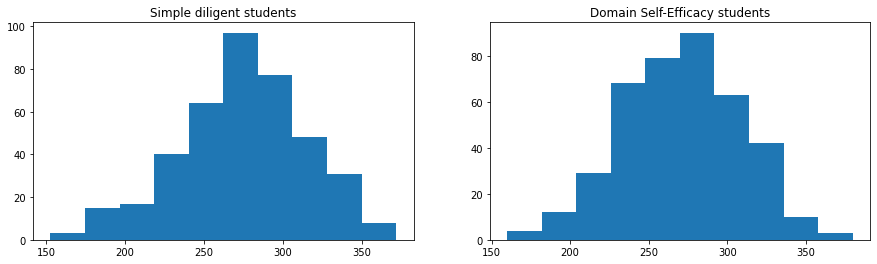

In [45]:
plt.figure(figsize=(15,4))
l = len(batch_descs)
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    col = 'total opportunity'
    plt.subplot(1,l, i+1)
    plt.hist(sstats['total opportunity'])
    plt.title(desc)    
plt.show()
    

### Detector error rates

In [46]:

# l = len(batch_descs)
# for i,desc in enumerate(batch_descs):
#     logger.info(f"************** {desc} ******************")
#     d = stu_stats[desc]
#     cols = [col for col in d.columns.tolist() if "offtask_" in str(col)]
#     dsum = d.loc[:,cols].apply(np.sum, axis=0)
#     total = np.sum(dsum)
#     dpct = dsum.apply(lambda x: x/total)
#     logger.info(f"Offtask Error Rates: \nTP: {dpct['offtask_tp']}\tFP: {dpct['offtask_fp']}\tTN: {dpct['offtask_tn']}\tFN: {dpct['offtask_fn']}")
#     cols = [col for col in d.columns.tolist() if "guess_" in str(col)]
#     dsum = d.loc[:,cols].apply(np.sum, axis=0)
#     total = np.sum(dsum)
#     dpct = dsum.apply(lambda x: x/total)
#     logger.info(f"Guess Error Rates: \nTP: {dpct['guess_tp']}\tFP: {dpct['guess_fp']}\tTN: {dpct['guess_tn']}\tFN: {dpct['guess_fn']}")


### Work Rate - Tutor Policy Overpractice

INFO:analytics.session:************** Simple diligent students ******************


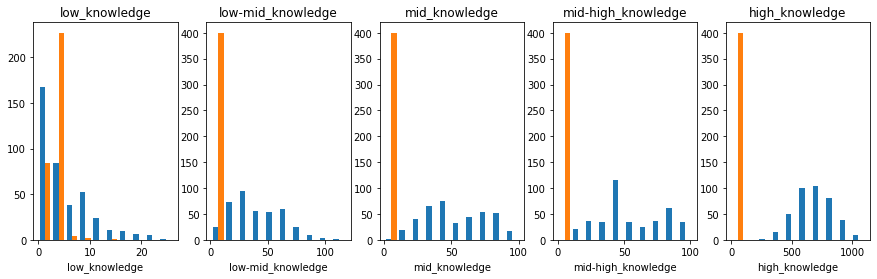

INFO:analytics.session:************** Domain Self-Efficacy students ******************


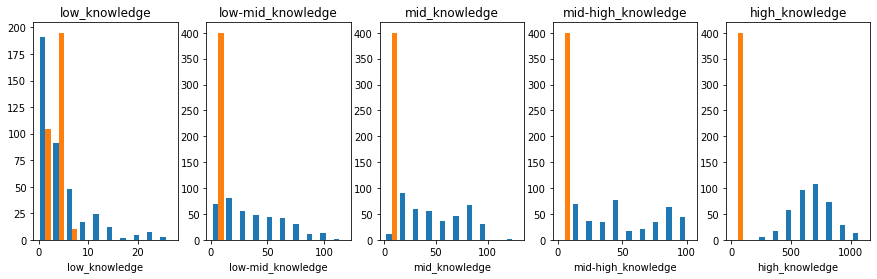

In [47]:

know_lvls = ['low_knowledge', 'low-mid_knowledge','mid_knowledge', 'mid-high_knowledge', 'high_knowledge']
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    logger.info(f"************** {desc} ******************")
    plt.figure(figsize=(15,4))    
    for j, col in enumerate(know_lvls):
        plt.subplot(1,len(know_lvls), j+1)
        plt.hist(sstats[col])
        plt.xlabel(col)
        plt.title(col)

    plt.show()

## Diligence

### Help-seeking

INFO:analytics.session:************** Simple diligent students ******************
INFO:analytics.session:Pct HintRequest Correlation with Diligence__diligence: 
R = 0.775447614620205	 pval = 1.7216225402881614e-81
INFO:analytics.session:Pct Attempt Correlation with Diligence__diligence: 
R = 0.41174154954279363	 pval = 8.45836222030217e-18
INFO:analytics.session:Pct FailedAttempt Correlation with Diligence__diligence: 
R = 0.5364669898316072	 pval = 3.4491527200312257e-31
INFO:analytics.session:Pct Guess Correlation with Diligence__diligence: 
R = -0.9227946587848258	 pval = 6.038124789005059e-167
INFO:analytics.session:Total Tx Correlation with Diligence__diligence: 
R = 0.17391031261077405	 pval = 0.00047587243781950267
INFO:analytics.session:Pct Hint Correlation with Diligence__diligence: 
R = 0.8178044210087214	 pval = 1.5326861557275339e-97


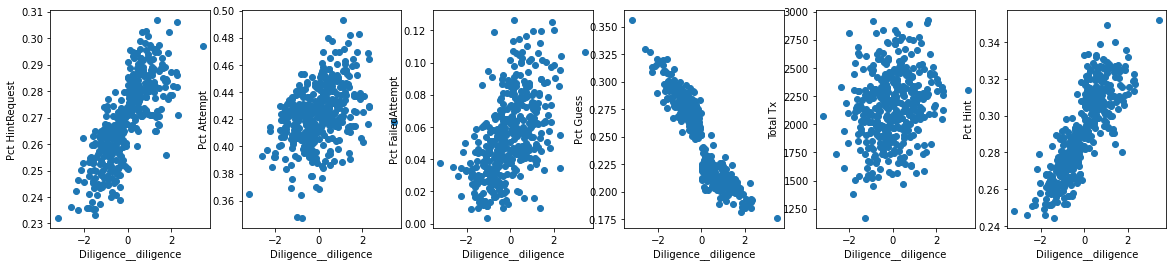

INFO:analytics.session:************** Domain Self-Efficacy students ******************
INFO:analytics.session:Pct HintRequest Correlation with Diligence__diligence: 
R = 0.5115434018008712	 pval = 4.687115279375458e-28
INFO:analytics.session:Pct Attempt Correlation with Diligence__diligence: 
R = 0.3705685514722294	 pval = 1.8208535668105764e-14
INFO:analytics.session:Pct FailedAttempt Correlation with Diligence__diligence: 
R = 0.20320663495795455	 pval = 4.2361203037814185e-05
INFO:analytics.session:Pct Guess Correlation with Diligence__diligence: 
R = -0.7317759518978071	 pval = 2.9329513332192366e-68
INFO:analytics.session:Total Tx Correlation with Diligence__diligence: 
R = 0.2822526194337159	 pval = 9.213740347232655e-09
INFO:analytics.session:Pct Hint Correlation with Diligence__diligence: 
R = 0.7050393618129425	 pval = 2.2419036717804225e-61


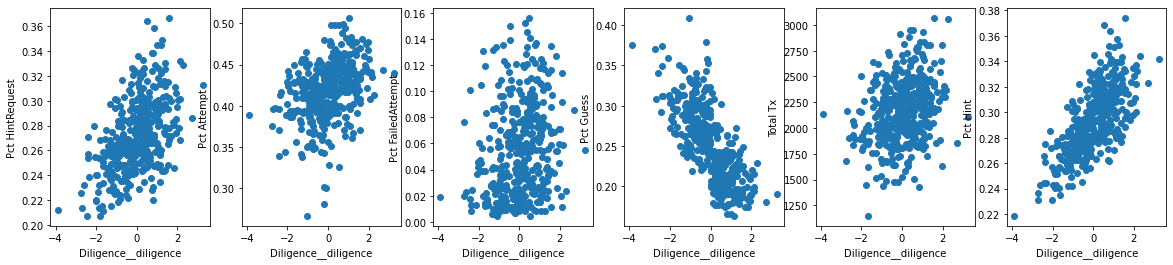

In [48]:

cols = ['Pct HintRequest', 'Pct Attempt', 'Pct FailedAttempt', 'Pct Guess', 'Total Tx', 'Pct Hint']
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    logger.info(f"************** {desc} ******************")
    plt.figure(figsize=(20,4))    
    for j, ycol in enumerate(cols):
        plt.subplot(1,len(cols), j+1)
        xcol = 'Diligence__diligence'
        x = sstats[xcol]
        y = sstats[ycol]
        plt.scatter(x,y)
        plt.xlabel(xcol)
        plt.ylabel(ycol)
        corr, pval = pearsonr(x,y)
        logger.info(f"{ycol} Correlation with {xcol}: \nR = {corr}\t pval = {pval}")


    plt.show()

### Total Time

INFO:analytics.session:************** Simple diligent students ******************
INFO:analytics.session:Total Time(hours) Correlation with Diligence__diligence: 
R = 0.2539693787025872	 pval = 2.630796724325603e-07
INFO:analytics.session:pct class Correlation with Diligence__diligence: 
R = 0.3116707423854938	 pval = 1.849503113879892e-10
INFO:analytics.session:start speed Correlation with Diligence__diligence: 
R = 0.20209505532567634	 pval = 4.674388083435244e-05
INFO:analytics.session:early finish Correlation with Diligence__diligence: 
R = -0.4124456262018725	 pval = 7.34775242170341e-18
INFO:analytics.session:session length Correlation with Diligence__diligence: 
R = 0.25881337363002566	 pval = 1.5227893515521197e-07


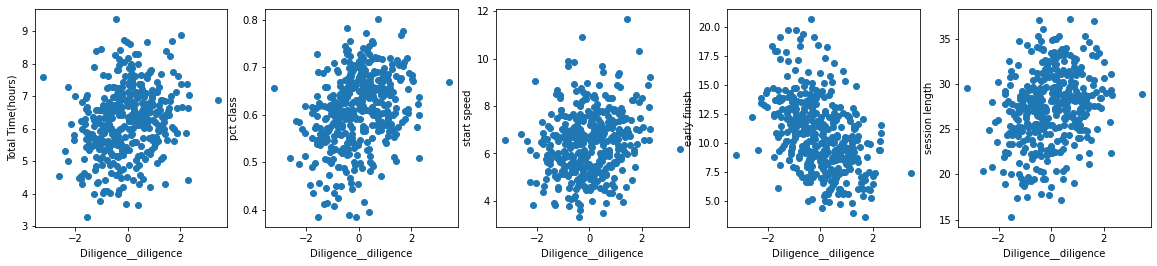

INFO:analytics.session:************** Domain Self-Efficacy students ******************
INFO:analytics.session:Total Time(hours) Correlation with Diligence__diligence: 
R = 0.18206661376640118	 pval = 0.0002516477428178097
INFO:analytics.session:pct class Correlation with Diligence__diligence: 
R = 0.30173725561800724	 pval = 7.273751458261428e-10
INFO:analytics.session:start speed Correlation with Diligence__diligence: 
R = 0.2193908797255891	 pval = 9.504502165265287e-06
INFO:analytics.session:early finish Correlation with Diligence__diligence: 
R = -0.3899646842285308	 pval = 5.600583288305152e-16
INFO:analytics.session:session length Correlation with Diligence__diligence: 
R = 0.2844171707562268	 pval = 7.015198865534576e-09


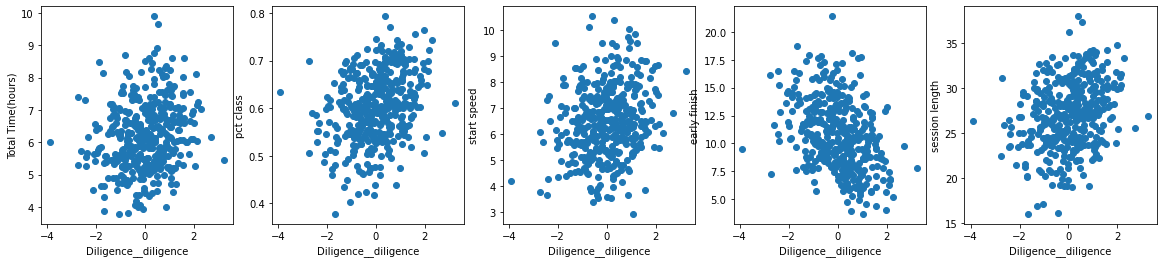

In [49]:

cols = ['Total Time(hours)', 'pct class', 'start speed', 'early finish', 'session length']
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    logger.info(f"************** {desc} ******************")
    plt.figure(figsize=(20,4))    
    for j, ycol in enumerate(cols):
        plt.subplot(1,len(cols), j+1)
        xcol = 'Diligence__diligence'
        x = sstats[xcol]
        y = sstats[ycol]
        plt.scatter(x,y)
        plt.xlabel(xcol)
        plt.ylabel(ycol)
        corr, pval = pearsonr(x,y)
        logger.info(f"{ycol} Correlation with {xcol}: \nR = {corr}\t pval = {pval}")


    plt.show()

### Off-task & Guessing

INFO:analytics.session:************** Simple diligent students ******************
INFO:analytics.session:OffTask Correlation with Diligence__diligence: 
R = -0.3681990013598463	 pval = 2.7425911442286823e-14
INFO:analytics.session:Pct OffTask Correlation with Diligence__diligence: 
R = -0.4224611582643746	 pval = 9.567046277896629e-19
INFO:analytics.session:Pct Guess Correlation with Diligence__diligence: 
R = -0.9227946587848258	 pval = 6.038124789005059e-167
INFO:analytics.session:mean_detect_offtask Correlation with Diligence__diligence: 
R = 0.22977882994805565	 pval = 3.4260388717651244e-06
INFO:analytics.session:mean_detect_guess Correlation with Diligence__diligence: 
R = -0.6568793394621145	 pval = 9.454395169407254e-51


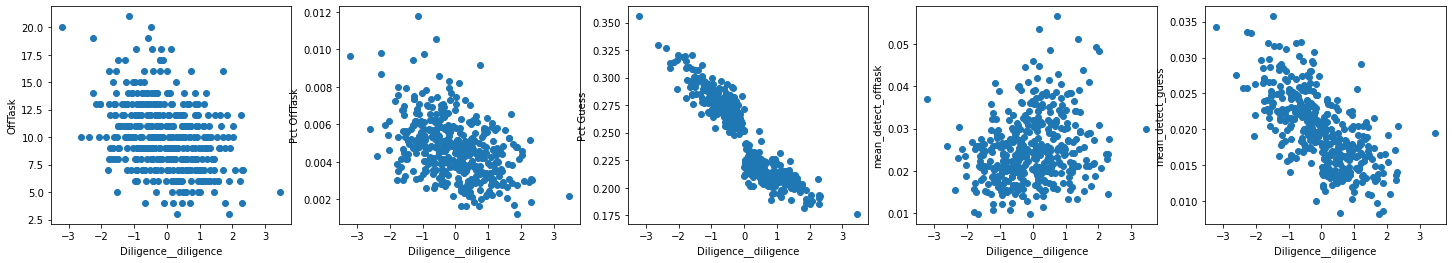

INFO:analytics.session:************** Domain Self-Efficacy students ******************
INFO:analytics.session:OffTask Correlation with Diligence__diligence: 
R = -0.25679128862629225	 pval = 1.9157862103302634e-07
INFO:analytics.session:Pct OffTask Correlation with Diligence__diligence: 
R = -0.35855903065379624	 pval = 1.4024882902495298e-13
INFO:analytics.session:Pct Guess Correlation with Diligence__diligence: 
R = -0.7317759518978071	 pval = 2.9329513332192366e-68
INFO:analytics.session:mean_detect_offtask Correlation with Diligence__diligence: 
R = 0.053286096921892734	 pval = 0.2877174625078764
INFO:analytics.session:mean_detect_guess Correlation with Diligence__diligence: 
R = -0.6714573428787788	 pval = 9.356646084211099e-54


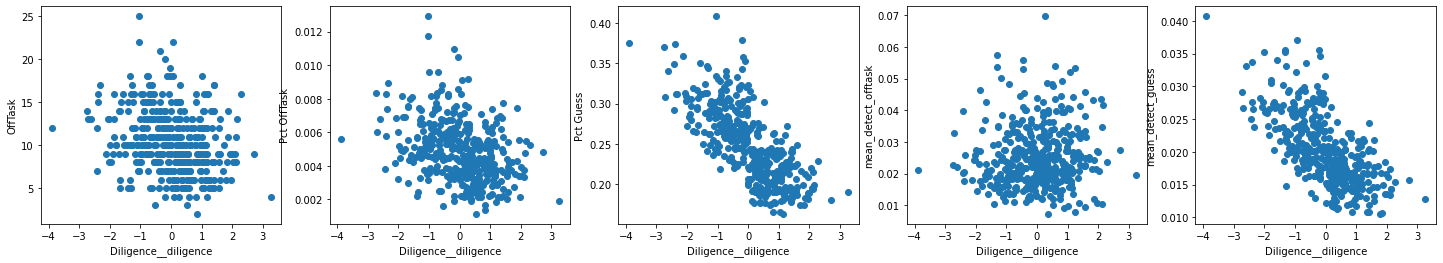

In [50]:

cols = ["OffTask", 'Pct OffTask', 'Pct Guess', 'mean_detect_offtask', 'mean_detect_guess']
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    logger.info(f"************** {desc} ******************")
    plt.figure(figsize=(25,4))    
    for j, ycol in enumerate(cols):
        plt.subplot(1,len(cols), j+1)
        xcol = 'Diligence__diligence'
        x = sstats[xcol]
        y = sstats[ycol]
        plt.scatter(x,y)
        plt.xlabel(xcol)
        plt.ylabel(ycol)
        corr, pval = pearsonr(x,y)
        logger.info(f"{ycol} Correlation with {xcol}: \nR = {corr}\t pval = {pval}")


    plt.show()

### Time-on-task

INFO:analytics.session:************** Simple diligent students ******************
INFO:analytics.session:Total Time(hours) Correlation with Diligence__diligence: 
R = 0.2539693787025872	 pval = 2.630796724325603e-07
INFO:analytics.session:time_on_task Correlation with Diligence__diligence: 
R = 0.57080041748762	 pval = 5.8925387471932796e-36
INFO:analytics.session:time_off_task Correlation with Diligence__diligence: 
R = -0.4244400194423483	 pval = 6.343328457018362e-19


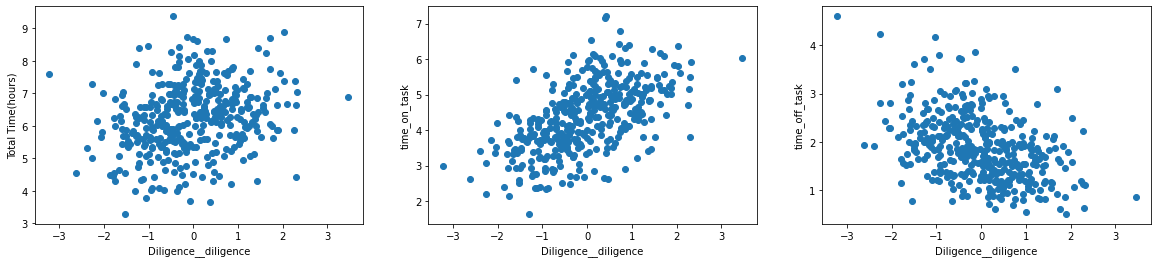

INFO:analytics.session:************** Domain Self-Efficacy students ******************
INFO:analytics.session:Total Time(hours) Correlation with Diligence__diligence: 
R = 0.18206661376640118	 pval = 0.0002516477428178097
INFO:analytics.session:time_on_task Correlation with Diligence__diligence: 
R = 0.42716249276162077	 pval = 3.58810933079705e-19
INFO:analytics.session:time_off_task Correlation with Diligence__diligence: 
R = -0.4094858565282989	 pval = 1.3248557747026094e-17


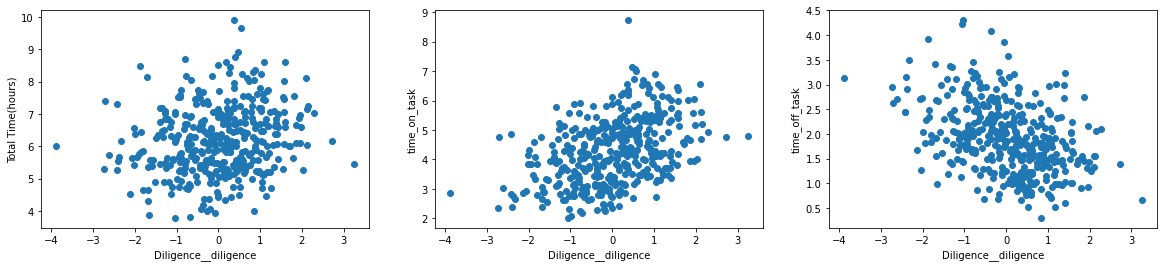

In [51]:

cols = ['Total Time(hours)', 'time_on_task', 'time_off_task']
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    logger.info(f"************** {desc} ******************")
    plt.figure(figsize=(20,4))    
    for j, ycol in enumerate(cols):
        plt.subplot(1,len(cols), j+1)
        xcol = 'Diligence__diligence'
        x = sstats[xcol]
        y = sstats[ycol]
        plt.scatter(x,y)
        plt.xlabel(xcol)
        plt.ylabel(ycol)
        corr, pval = pearsonr(x,y)
        logger.info(f"{ycol} Correlation with {xcol}: \nR = {corr}\t pval = {pval}")


    plt.show()

### Knowledge & Learning

INFO:analytics.session:************** Simple diligent students ******************
INFO:analytics.session:pre-sim total skill Correlation with Diligence__diligence: 
R = 0.023503350782701077	 pval = 0.6393121922262118
INFO:analytics.session:final-sim total skill Correlation with Diligence__diligence: 
R = 0.09030568192978503	 pval = 0.07120791730533199
INFO:analytics.session:final-sim total mastery Correlation with Diligence__diligence: 
R = 0.4470414219676597	 pval = 4.771698722669212e-21
INFO:analytics.session:total learning Correlation with Diligence__diligence: 
R = 0.6161727193802473	 pval = 3.4863060486863238e-43
INFO:analytics.session:total mastered Correlation with Diligence__diligence: 
R = 0.5889573431415646	 pval = 1.03382796602311e-38


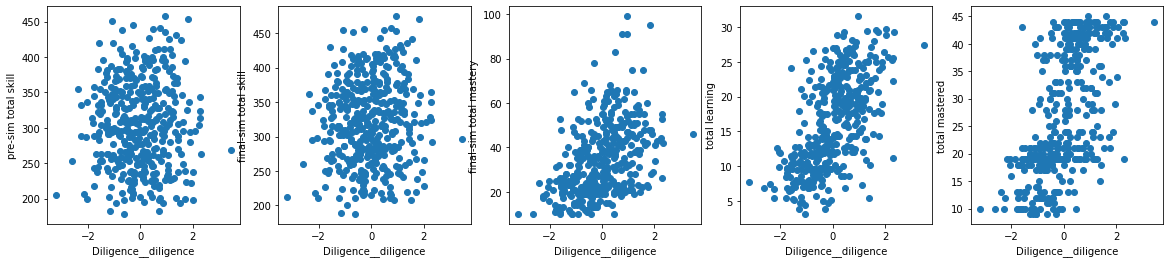

INFO:analytics.session:************** Domain Self-Efficacy students ******************
INFO:analytics.session:pre-sim total skill Correlation with Diligence__diligence: 
R = 0.02147671255788983	 pval = 0.66847681895283
INFO:analytics.session:final-sim total skill Correlation with Diligence__diligence: 
R = 0.06329544267208825	 pval = 0.20651223192012788
INFO:analytics.session:final-sim total mastery Correlation with Diligence__diligence: 
R = 0.2359393117165694	 pval = 1.8281419315846356e-06
INFO:analytics.session:total learning Correlation with Diligence__diligence: 
R = 0.33300493098330114	 pval = 8.182530888341673e-12
INFO:analytics.session:total mastered Correlation with Diligence__diligence: 
R = 0.34482488737868955	 pval = 1.306246469625333e-12


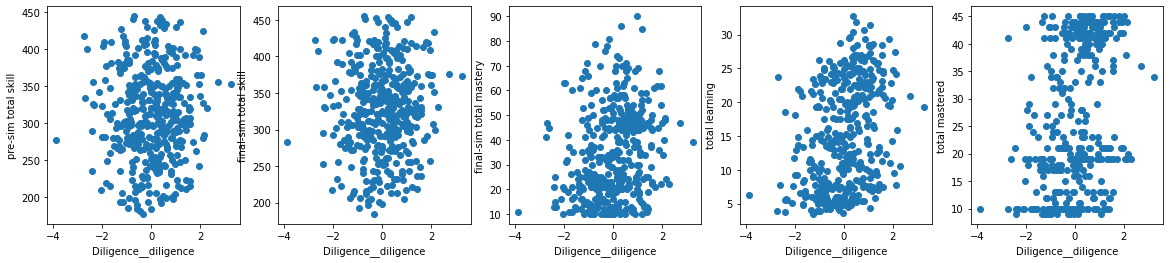

In [52]:

cols = ['pre-sim total skill', 'final-sim total skill', 'final-sim total mastery', 'total learning', 'total mastered']
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    logger.info(f"************** {desc} ******************")
    plt.figure(figsize=(20,4))    
    for j, ycol in enumerate(cols):
        plt.subplot(1,len(cols), j+1)
        xcol = 'Diligence__diligence'
        x = sstats[xcol]
        y = sstats[ycol]
        plt.scatter(x,y)
        plt.xlabel(xcol)
        plt.ylabel(ycol)
        corr, pval = pearsonr(x,y)
        logger.info(f"{ycol} Correlation with {xcol}: \nR = {corr}\t pval = {pval}")


    plt.show()

## Cog Ability

### Knowledge & Learning

INFO:analytics.session:************** Simple diligent students ******************
INFO:analytics.session:pre-sim total skill Correlation with cog_ability: 
R = 0.9973316263522201	 pval = 0.0
INFO:analytics.session:final-sim total skill Correlation with cog_ability: 
R = 0.9922450567164602	 pval = 0.0
INFO:analytics.session:final-sim total mastery Correlation with cog_ability: 
R = 0.6966298334752963	 pval = 2.280412950041005e-59
INFO:analytics.session:total learning Correlation with cog_ability: 
R = -0.07322876694639216	 pval = 0.14375344660088235
INFO:analytics.session:total mastered Correlation with cog_ability: 
R = 0.3098376865549073	 pval = 2.390463246913466e-10


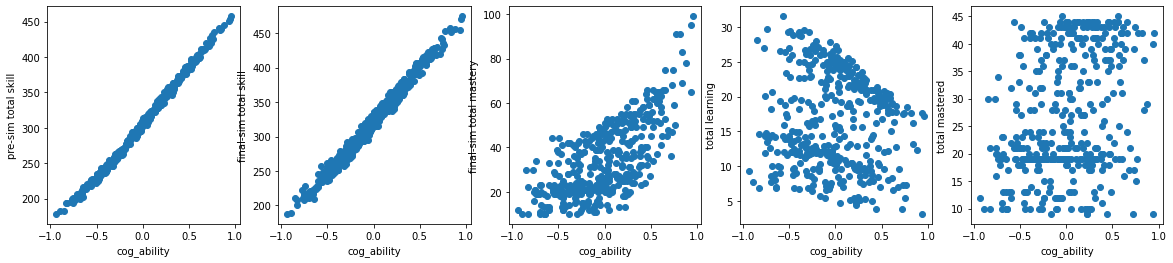

INFO:analytics.session:************** Domain Self-Efficacy students ******************
INFO:analytics.session:pre-sim total skill Correlation with cog_ability: 
R = 0.9971811092413762	 pval = 0.0
INFO:analytics.session:final-sim total skill Correlation with cog_ability: 
R = 0.9900900845878933	 pval = 0.0
INFO:analytics.session:final-sim total mastery Correlation with cog_ability: 
R = 0.6641139790503428	 pval = 3.2043685953596688e-52
INFO:analytics.session:total learning Correlation with cog_ability: 
R = -0.05237615814355541	 pval = 0.2960403888862761
INFO:analytics.session:total mastered Correlation with cog_ability: 
R = 0.26164160326422475	 pval = 1.1009440243912433e-07


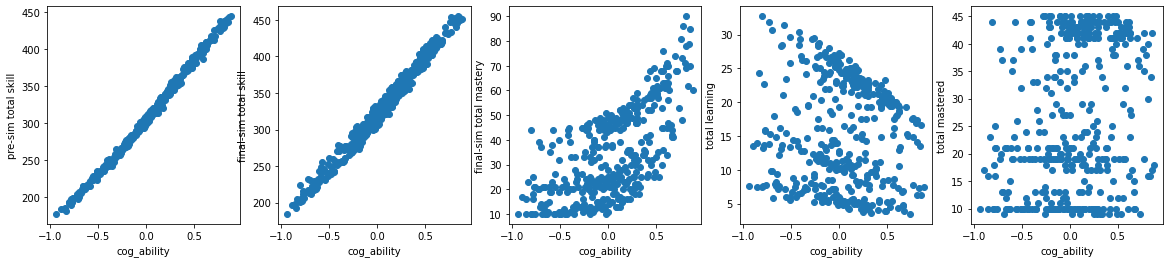

In [53]:

cols = ['pre-sim total skill', 'final-sim total skill', 'final-sim total mastery', 'total learning', 'total mastered']
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    logger.info(f"************** {desc} ******************")
    plt.figure(figsize=(20,4))    
    for j, ycol in enumerate(cols):
        plt.subplot(1,len(cols), j+1)
        xcol = 'cog_ability'
        x = sstats[xcol]
        y = sstats[ycol]
        plt.scatter(x,y)
        plt.xlabel(xcol)
        plt.ylabel(ycol)
        corr, pval = pearsonr(x,y)
        logger.info(f"{ycol} Correlation with {xcol}: \nR = {corr}\t pval = {pval}")


    plt.show()

### Help-seeking

INFO:analytics.session:************** Simple diligent students ******************
INFO:analytics.session:Pct HintRequest Correlation with cog_ability: 
R = 0.02563299689685333	 pval = 0.609253335614402
INFO:analytics.session:Pct Attempt Correlation with cog_ability: 
R = 0.45876684946388235	 pval = 3.2571386146550104e-22
INFO:analytics.session:Pct FailedAttempt Correlation with cog_ability: 
R = -0.37660531519733376	 pval = 6.315899813166544e-15
INFO:analytics.session:Pct Guess Correlation with cog_ability: 
R = -0.018492691329007084	 pval = 0.7123305493847429
INFO:analytics.session:Total Tx Correlation with cog_ability: 
R = 0.027859341490840794	 pval = 0.5785178671261071
INFO:analytics.session:Pct Hint Correlation with cog_ability: 
R = -0.1721137132974324	 pval = 0.0005455438871275098


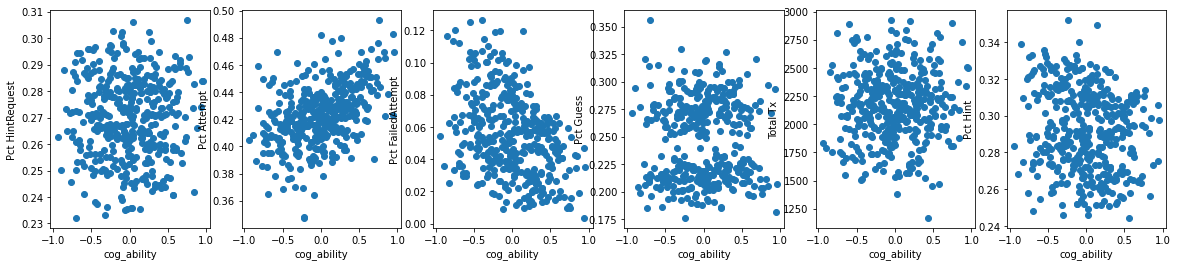

INFO:analytics.session:************** Domain Self-Efficacy students ******************
INFO:analytics.session:Pct HintRequest Correlation with cog_ability: 
R = -0.024720366233837145	 pval = 0.6220582247498337
INFO:analytics.session:Pct Attempt Correlation with cog_ability: 
R = 0.3651171025735211	 pval = 4.648825567381855e-14
INFO:analytics.session:Pct FailedAttempt Correlation with cog_ability: 
R = -0.25506136477482433	 pval = 2.3279849864787332e-07
INFO:analytics.session:Pct Guess Correlation with cog_ability: 
R = -0.0585973498656826	 pval = 0.24228909422054762
INFO:analytics.session:Total Tx Correlation with cog_ability: 
R = -0.08033669493721488	 pval = 0.10864803294264813
INFO:analytics.session:Pct Hint Correlation with cog_ability: 
R = -0.17851814541186117	 pval = 0.0003331572141862083


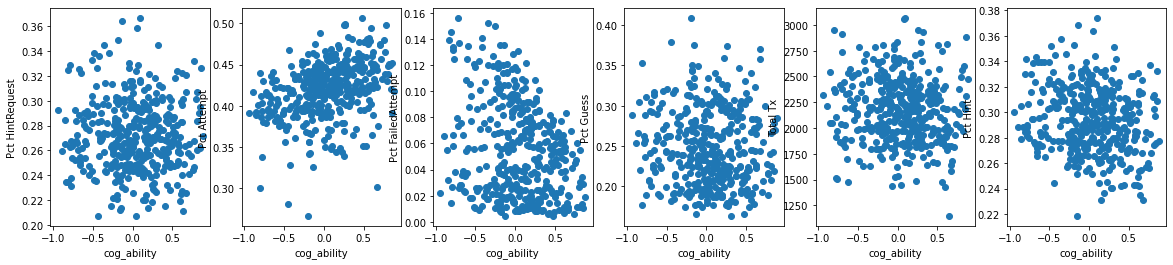

In [54]:

cols = ['Pct HintRequest', 'Pct Attempt', 'Pct FailedAttempt', 'Pct Guess', 'Total Tx', 'Pct Hint']
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    logger.info(f"************** {desc} ******************")
    plt.figure(figsize=(20,4))    
    for j, ycol in enumerate(cols):
        plt.subplot(1,len(cols), j+1)
        xcol = 'cog_ability'
        x = sstats[xcol]
        y = sstats[ycol]
        plt.scatter(x,y)
        plt.xlabel(xcol)
        plt.ylabel(ycol)
        corr, pval = pearsonr(x,y)
        logger.info(f"{ycol} Correlation with {xcol}: \nR = {corr}\t pval = {pval}")


    plt.show()

### Early Finish

INFO:analytics.session:************** Simple diligent students ******************
INFO:analytics.session:start speed Correlation with cog_ability: 
R = -0.042430150340369274	 pval = 0.3973695155711689
INFO:analytics.session:early finish Correlation with cog_ability: 
R = -0.016478601870532572	 pval = 0.7424860548490545
INFO:analytics.session:pct class Correlation with cog_ability: 
R = 0.04264446295340556	 pval = 0.39498762005339294
INFO:analytics.session:session length Correlation with cog_ability: 
R = 0.06382281147197001	 pval = 0.20274831147380848


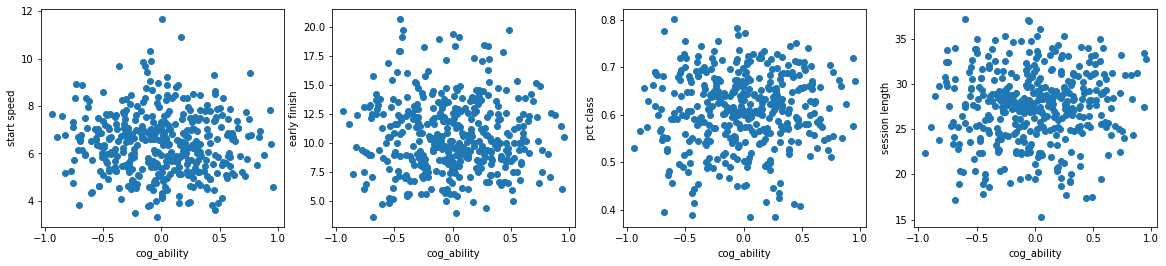

INFO:analytics.session:************** Domain Self-Efficacy students ******************
INFO:analytics.session:start speed Correlation with cog_ability: 
R = 0.048760906891619715	 pval = 0.3306800949605508
INFO:analytics.session:early finish Correlation with cog_ability: 
R = -0.07060601091510174	 pval = 0.1586990377227899
INFO:analytics.session:pct class Correlation with cog_ability: 
R = 0.0473658403251598	 pval = 0.3447188158289864
INFO:analytics.session:session length Correlation with cog_ability: 
R = 0.02257144704411392	 pval = 0.6526574168817992


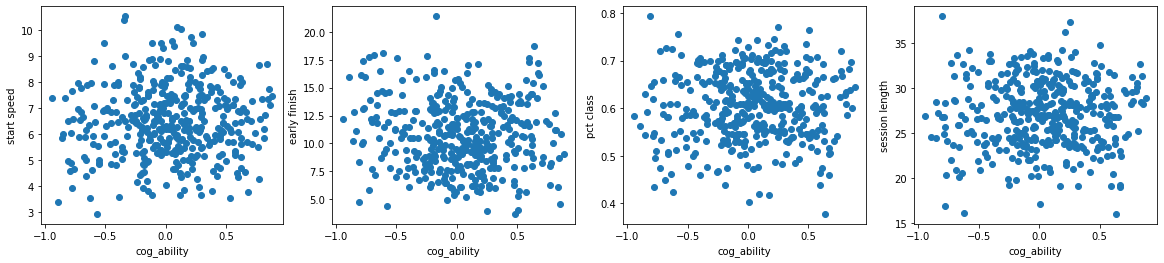

In [55]:

cols = ['start speed', 'early finish', 'pct class', 'session length']
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    logger.info(f"************** {desc} ******************")
    plt.figure(figsize=(20,4))    
    for j, ycol in enumerate(cols):
        plt.subplot(1,len(cols), j+1)
        xcol = 'cog_ability'
        x = sstats[xcol]
        y = sstats[ycol]
        plt.scatter(x,y)
        plt.xlabel(xcol)
        plt.ylabel(ycol)
        corr, pval = pearsonr(x,y)
        logger.info(f"{ycol} Correlation with {xcol}: \nR = {corr}\t pval = {pval}")


    plt.show()

### Work Rate

### Offtask

INFO:analytics.session:************** Simple diligent students ******************
INFO:analytics.session:Pct OffTask Correlation with cog_ability: 
R = -0.10526308256510195	 pval = 0.03533284167883866
INFO:analytics.session:time_off_task Correlation with cog_ability: 
R = -0.14305247875646487	 pval = 0.004145737602291151
INFO:analytics.session:mean_detect_offtask Correlation with cog_ability: 
R = -0.5005559614540656	 pval = 9.378876052161152e-27
INFO:analytics.session:time_on_task Correlation with cog_ability: 
R = -0.06272836189948819	 pval = 0.21061569876575567


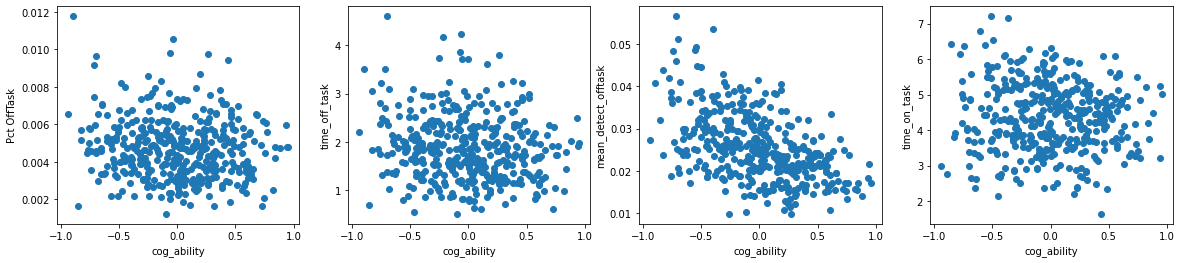

INFO:analytics.session:************** Domain Self-Efficacy students ******************
INFO:analytics.session:Pct OffTask Correlation with cog_ability: 
R = -0.03618921212790793	 pval = 0.470444745282485
INFO:analytics.session:time_off_task Correlation with cog_ability: 
R = -0.1340571661363914	 pval = 0.0072555465211073126
INFO:analytics.session:mean_detect_offtask Correlation with cog_ability: 
R = -0.3860861923701596	 pval = 1.1446675715881491e-15
INFO:analytics.session:time_on_task Correlation with cog_ability: 
R = -0.08504367126286684	 pval = 0.08938911129928528


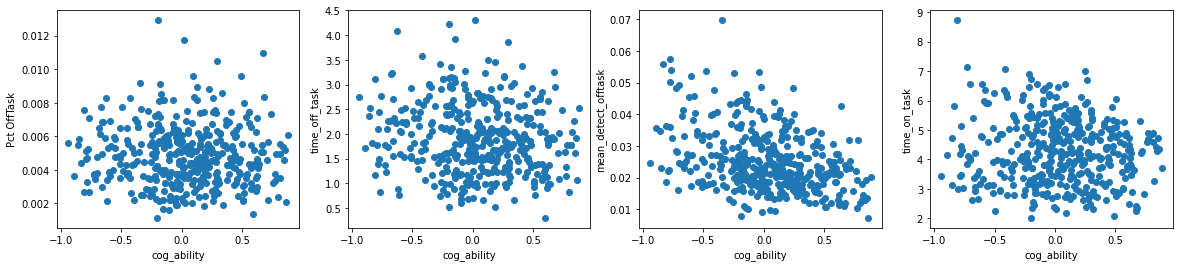

In [56]:

cols = ['Pct OffTask', 'time_off_task', 'mean_detect_offtask', 'time_on_task']
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    logger.info(f"************** {desc} ******************")
    plt.figure(figsize=(20,4))    
    for j, ycol in enumerate(cols):
        plt.subplot(1,len(cols), j+1)
        xcol = 'cog_ability'
        x = sstats[xcol]
        y = sstats[ycol]
        plt.scatter(x,y)
        plt.xlabel(xcol)
        plt.ylabel(ycol)
        corr, pval = pearsonr(x,y)
        logger.info(f"{ycol} Correlation with {xcol}: \nR = {corr}\t pval = {pval}")


    plt.show()

## Domain Self-efficacy

### Help-seeking

INFO:analytics.session:************** Domain Self-Efficacy students ******************
INFO:analytics.session:Pct HintRequest Correlation with DomainSelfEff__self_eff: 
R = -0.815556112764275	 pval = 1.3792453804178286e-96
INFO:analytics.session:Pct Attempt Correlation with DomainSelfEff__self_eff: 
R = 0.6371741857415625	 pval = 6.035503340201514e-47
INFO:analytics.session:Pct FailedAttempt Correlation with DomainSelfEff__self_eff: 
R = 0.7554156606774602	 pval = 4.483744920341605e-75
INFO:analytics.session:Pct Guess Correlation with DomainSelfEff__self_eff: 
R = -0.5440680352756693	 pval = 3.382639076393553e-32
INFO:analytics.session:Total Tx Correlation with DomainSelfEff__self_eff: 
R = -0.21108348412602662	 pval = 2.0764008789750157e-05
INFO:analytics.session:Pct Hint Correlation with DomainSelfEff__self_eff: 
R = -0.5510074070261127	 pval = 3.853621750589023e-33


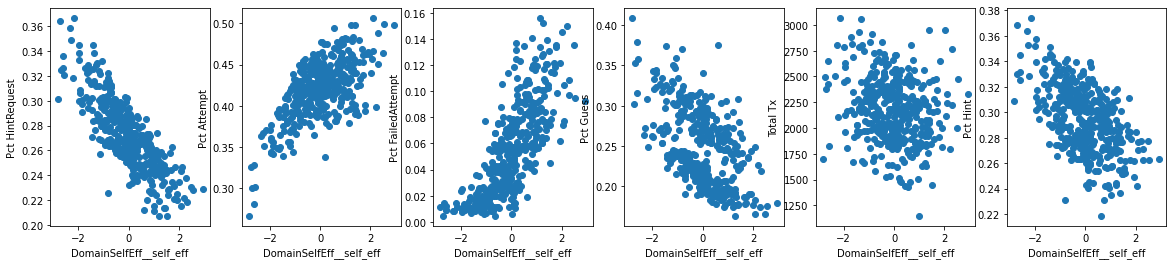

In [57]:

cols = ['Pct HintRequest', 'Pct Attempt', 'Pct FailedAttempt', 'Pct Guess', 'Total Tx', 'Pct Hint']
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    if 'DomainSelfEff__self_eff' in sstats.columns:
        logger.info(f"************** {desc} ******************")
        plt.figure(figsize=(20,4))    
        for j, ycol in enumerate(cols):
            plt.subplot(1,len(cols), j+1)
            xcol = 'DomainSelfEff__self_eff'
            x = sstats[xcol]
            y = sstats[ycol]
            plt.scatter(x,y)
            plt.xlabel(xcol)
            plt.ylabel(ycol)
            corr, pval = pearsonr(x,y)
            logger.info(f"{ycol} Correlation with {xcol}: \nR = {corr}\t pval = {pval}")


        plt.show()

### Total Time

INFO:analytics.session:************** Domain Self-Efficacy students ******************
INFO:analytics.session:Total Time(hours) Correlation with DomainSelfEff__self_eff: 
R = 0.40520125795569006	 pval = 3.078211223755978e-17
INFO:analytics.session:pct class Correlation with DomainSelfEff__self_eff: 
R = 0.23280547383951022	 pval = 2.5217976801202293e-06
INFO:analytics.session:start speed Correlation with DomainSelfEff__self_eff: 
R = 0.05280811339049714	 pval = 0.29206961887111915
INFO:analytics.session:early finish Correlation with DomainSelfEff__self_eff: 
R = -0.26197466956209536	 pval = 1.059414808010936e-07
INFO:analytics.session:session length Correlation with DomainSelfEff__self_eff: 
R = 0.21103703394537432	 pval = 2.0853153288055394e-05


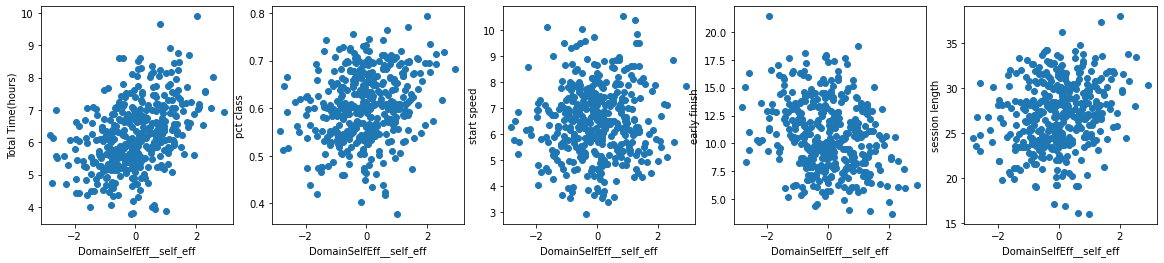

In [58]:

cols = ['Total Time(hours)', 'pct class', 'start speed', 'early finish', 'session length']
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    if 'DomainSelfEff__self_eff' in sstats.columns:

        logger.info(f"************** {desc} ******************")
        plt.figure(figsize=(20,4))    
        for j, ycol in enumerate(cols):
            plt.subplot(1,len(cols), j+1)
            xcol = 'DomainSelfEff__self_eff'
            x = sstats[xcol]
            y = sstats[ycol]
            plt.scatter(x,y)
            plt.xlabel(xcol)
            plt.ylabel(ycol)
            corr, pval = pearsonr(x,y)
            logger.info(f"{ycol} Correlation with {xcol}: \nR = {corr}\t pval = {pval}")


        plt.show()

### Off-task & Guessing

INFO:analytics.session:************** Domain Self-Efficacy students ******************
INFO:analytics.session:OffTask Correlation with DomainSelfEff__self_eff: 
R = -0.4714046234221281	 pval = 1.6026952583165917e-23
INFO:analytics.session:Pct OffTask Correlation with DomainSelfEff__self_eff: 
R = -0.3623080007074132	 pval = 7.483506812479115e-14
INFO:analytics.session:Pct Guess Correlation with DomainSelfEff__self_eff: 
R = -0.5440680352756693	 pval = 3.382639076393553e-32
INFO:analytics.session:mean_detect_offtask Correlation with DomainSelfEff__self_eff: 
R = 0.541933216697777	 pval = 6.532587592446724e-32
INFO:analytics.session:mean_detect_guess Correlation with DomainSelfEff__self_eff: 
R = -0.2517350865621908	 pval = 3.372784117303233e-07


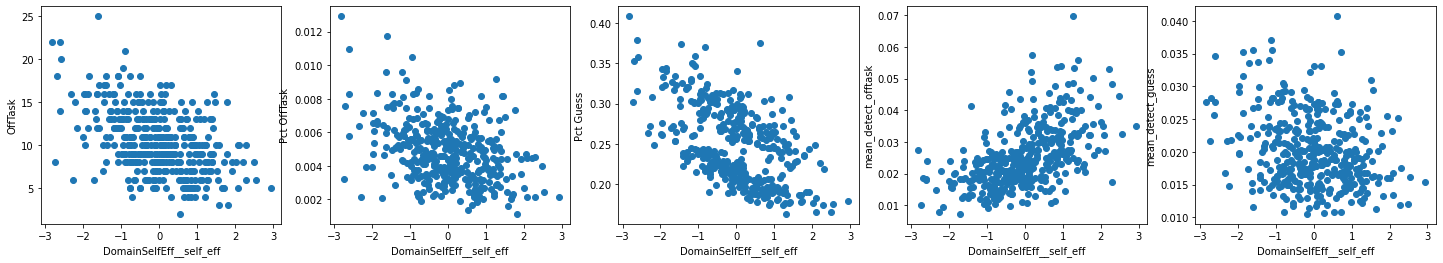

In [59]:

cols = ["OffTask", 'Pct OffTask', 'Pct Guess', 'mean_detect_offtask', 'mean_detect_guess']
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    if 'DomainSelfEff__self_eff' in sstats.columns:

        logger.info(f"************** {desc} ******************")
        plt.figure(figsize=(25,4))    
        for j, ycol in enumerate(cols):
            plt.subplot(1,len(cols), j+1)
            xcol = 'DomainSelfEff__self_eff'
            x = sstats[xcol]
            y = sstats[ycol]
            plt.scatter(x,y)
            plt.xlabel(xcol)
            plt.ylabel(ycol)
            corr, pval = pearsonr(x,y)
            logger.info(f"{ycol} Correlation with {xcol}: \nR = {corr}\t pval = {pval}")


        plt.show()

### Time-on-task

INFO:analytics.session:************** Domain Self-Efficacy students ******************
INFO:analytics.session:Total Time(hours) Correlation with DomainSelfEff__self_eff: 
R = 0.40520125795569006	 pval = 3.078211223755978e-17
INFO:analytics.session:time_on_task Correlation with DomainSelfEff__self_eff: 
R = 0.5907926056091422	 pval = 5.322785166141417e-39
INFO:analytics.session:time_off_task Correlation with DomainSelfEff__self_eff: 
R = -0.3378496572850277	 pval = 3.893751555453892e-12


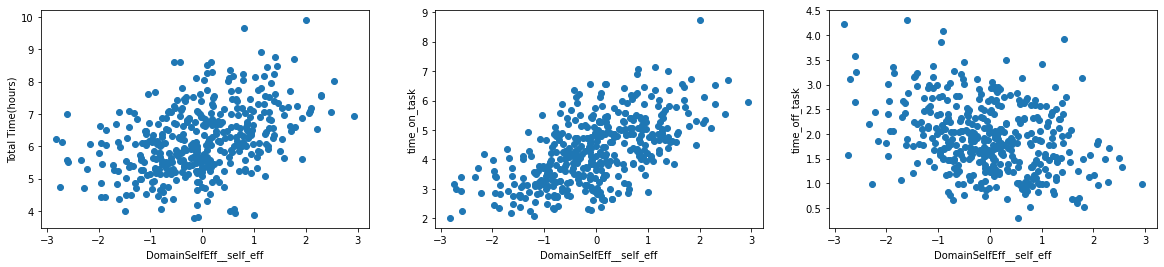

In [60]:

cols = ['Total Time(hours)', 'time_on_task', 'time_off_task']
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    if 'DomainSelfEff__self_eff' in sstats.columns:
        logger.info(f"************** {desc} ******************")
        plt.figure(figsize=(20,4))    
        for j, ycol in enumerate(cols):
            plt.subplot(1,len(cols), j+1)
            xcol = 'DomainSelfEff__self_eff'
            x = sstats[xcol]
            y = sstats[ycol]
            plt.scatter(x,y)
            plt.xlabel(xcol)
            plt.ylabel(ycol)
            corr, pval = pearsonr(x,y)
            logger.info(f"{ycol} Correlation with {xcol}: \nR = {corr}\t pval = {pval}")


        plt.show()

### Knowledge & Learning

INFO:analytics.session:************** Domain Self-Efficacy students ******************
INFO:analytics.session:pre-sim total skill Correlation with DomainSelfEff__self_eff: 
R = 0.0476919416852708	 pval = 0.3414037674265372
INFO:analytics.session:final-sim total skill Correlation with DomainSelfEff__self_eff: 
R = 0.13517689151756862	 pval = 0.0067789060749880534
INFO:analytics.session:final-sim total mastery Correlation with DomainSelfEff__self_eff: 
R = 0.5110235709742957	 pval = 5.414255245634387e-28
INFO:analytics.session:total learning Correlation with DomainSelfEff__self_eff: 
R = 0.6966589307798071	 pval = 2.2448536421678367e-59
INFO:analytics.session:total mastered Correlation with DomainSelfEff__self_eff: 
R = 0.6711548002685315	 pval = 1.084470187956164e-53


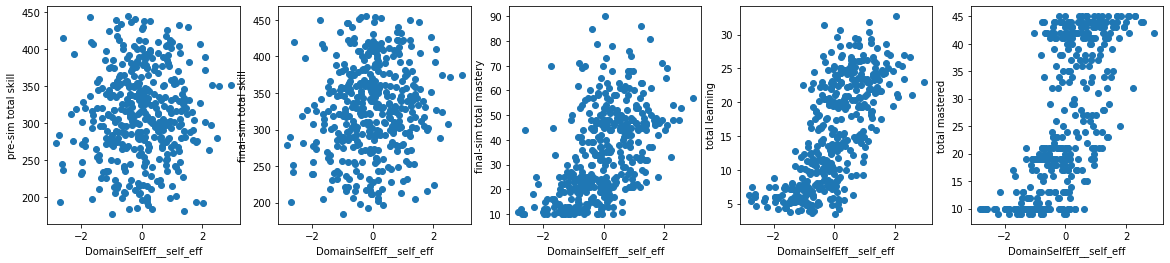

In [61]:

cols = ['pre-sim total skill', 'final-sim total skill', 'final-sim total mastery', 'total learning', 'total mastered']
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    if 'DomainSelfEff__self_eff' in sstats.columns:
        logger.info(f"************** {desc} ******************")
        plt.figure(figsize=(20,4))    
        for j, ycol in enumerate(cols):
            plt.subplot(1,len(cols), j+1)
            xcol = 'DomainSelfEff__self_eff'
            x = sstats[xcol]
            y = sstats[ycol]
            plt.scatter(x,y)
            plt.xlabel(xcol)
            plt.ylabel(ycol)
            corr, pval = pearsonr(x,y)
            logger.info(f"{ycol} Correlation with {xcol}: \nR = {corr}\t pval = {pval}")


        plt.show()

# BIRT Experimentation

INFO:analytics.session:**************************************************
INFO:analytics.session:**************************************************
INFO:analytics.session:**************************************************
INFO:analytics.session:**************************************************
INFO:analytics.session:**************************************************
INFO:analytics.session:************** Simple diligent students ******************
INFO:analytics.session:**************************************************
INFO:analytics.session:**************************************************
INFO:analytics.session:**************************************************
INFO:analytics.session:**************************************************
INFO:analytics.session:**************************************************
INFO:analytics.session:Pct Attempt Correlation with Diligence__diligence over all data: 
R = 0.41174154954279363	 pval = 8.45836222030217e-18
<ipython-input-141-bfd63fc12296>:30:

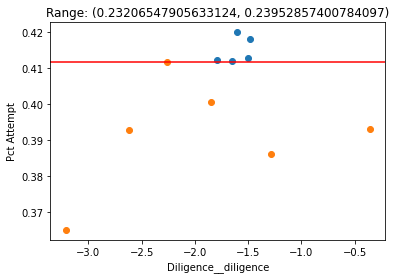

INFO:analytics.session:******** P-Hint range: (0.23952857400784097, 0.2469916689593507) *********
INFO:analytics.session:Number of rows: 22
INFO:analytics.session:0.4217172908149205
INFO:analytics.session:Pct Attempt Correlation with Diligence__diligence over range (0.23952857400784097, 0.2469916689593507): 
R = 0.4277494395601116	 pval = 0.04705191658924746


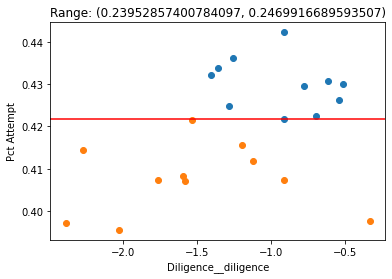

INFO:analytics.session:******** P-Hint range: (0.2469916689593507, 0.2544547639108604) *********
INFO:analytics.session:Number of rows: 41
INFO:analytics.session:0.4142147497134123
INFO:analytics.session:Pct Attempt Correlation with Diligence__diligence over range (0.2469916689593507, 0.2544547639108604): 
R = -0.09719919548911697	 pval = 0.5454676991228332


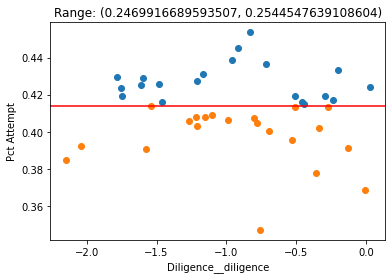

INFO:analytics.session:******** P-Hint range: (0.2544547639108604, 0.2619178588623702) *********
INFO:analytics.session:Number of rows: 49
INFO:analytics.session:0.41933287950987064
INFO:analytics.session:Pct Attempt Correlation with Diligence__diligence over range (0.2544547639108604, 0.2619178588623702): 
R = 0.28461795273927787	 pval = 0.047468246797564874


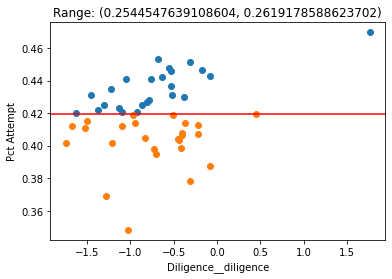

INFO:analytics.session:******** P-Hint range: (0.2619178588623702, 0.26938095381387994) *********
INFO:analytics.session:Number of rows: 69
INFO:analytics.session:0.4159719175076788
INFO:analytics.session:Pct Attempt Correlation with Diligence__diligence over range (0.2619178588623702, 0.26938095381387994): 
R = 0.3847162910010864	 pval = 0.001098860551846971


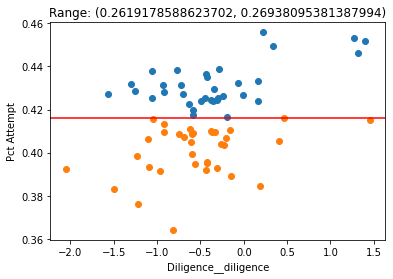

INFO:analytics.session:******** P-Hint range: (0.26938095381387994, 0.2768440487653897) *********
INFO:analytics.session:Number of rows: 63
INFO:analytics.session:0.42749244712990936
INFO:analytics.session:Pct Attempt Correlation with Diligence__diligence over range (0.26938095381387994, 0.2768440487653897): 
R = 0.299560510778261	 pval = 0.017073110779004613


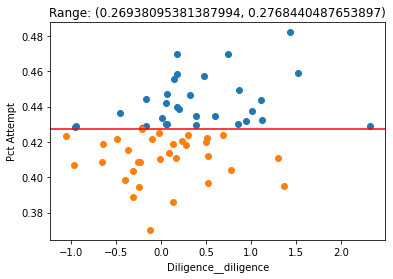

INFO:analytics.session:******** P-Hint range: (0.27684404876538965, 0.28430714371689936) *********
INFO:analytics.session:Number of rows: 69
INFO:analytics.session:0.4287677508016491
INFO:analytics.session:Pct Attempt Correlation with Diligence__diligence over range (0.27684404876538965, 0.28430714371689936): 
R = 0.0953752841002708	 pval = 0.43565424314998125


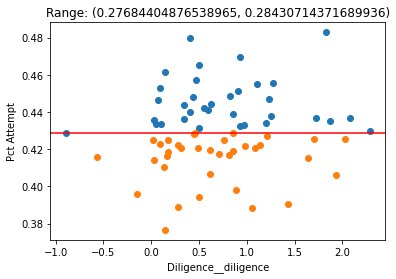

INFO:analytics.session:******** P-Hint range: (0.28430714371689936, 0.2917702386684091) *********
INFO:analytics.session:Number of rows: 44
INFO:analytics.session:0.43081919061881657
INFO:analytics.session:Pct Attempt Correlation with Diligence__diligence over range (0.28430714371689936, 0.2917702386684091): 
R = 0.3615386572593706	 pval = 0.01589451830806678


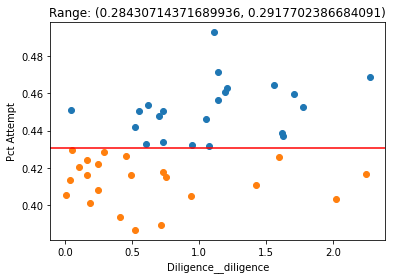

INFO:analytics.session:******** P-Hint range: (0.2917702386684091, 0.2992333336199189) *********
INFO:analytics.session:Number of rows: 26
INFO:analytics.session:0.4403173960208745
INFO:analytics.session:Pct Attempt Correlation with Diligence__diligence over range (0.2917702386684091, 0.2992333336199189): 
R = -0.4170344167088511	 pval = 0.03404456358398078


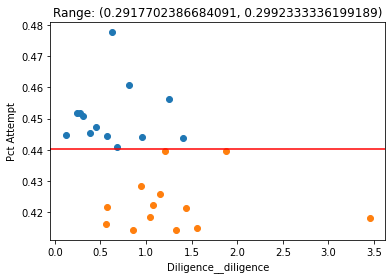

INFO:analytics.session:******** P-Hint range: (0.2992333336199189, 0.30669642857142865) *********
INFO:analytics.session:Number of rows: 6
INFO:analytics.session:0.4444057180141762
INFO:analytics.session:Pct Attempt Correlation with Diligence__diligence over range (0.2992333336199189, 0.30669642857142865): 
R = 0.4153793872000343	 pval = 0.412765706267359


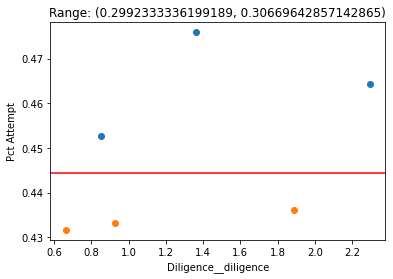

INFO:analytics.session:(0.23206547905633124, 0.23952857400784097)    0.411552
(0.23952857400784097, 0.2469916689593507)     0.421717
(0.2469916689593507, 0.2544547639108604)      0.414215
(0.2544547639108604, 0.2619178588623702)      0.419333
(0.2619178588623702, 0.26938095381387994)     0.415972
(0.26938095381387994, 0.2768440487653897)     0.427492
(0.27684404876538965, 0.28430714371689936)    0.428768
(0.28430714371689936, 0.2917702386684091)     0.430819
(0.2917702386684091, 0.2992333336199189)      0.440317
(0.2992333336199189, 0.30669642857142865)     0.444406
dtype: float64
INFO:analytics.session:**************************************************
INFO:analytics.session:**************************************************
INFO:analytics.session:**************************************************
INFO:analytics.session:**************************************************
INFO:analytics.session:**************************************************
INFO:analytics.session:************** Doma

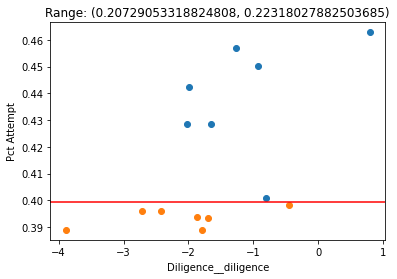

INFO:analytics.session:******** P-Hint range: (0.22318027882503685, 0.23907002446182563) *********
INFO:analytics.session:Number of rows: 29
INFO:analytics.session:0.42571127502634354
INFO:analytics.session:Pct Attempt Correlation with Diligence__diligence over range (0.22318027882503685, 0.23907002446182563): 
R = 0.5734477499326215	 pval = 0.001146029549336112


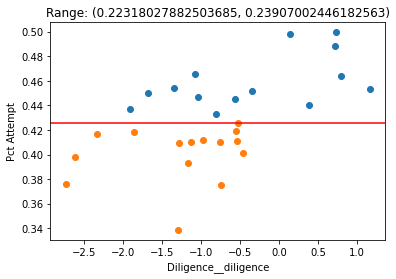

INFO:analytics.session:******** P-Hint range: (0.23907002446182563, 0.25495977009861437) *********
INFO:analytics.session:Number of rows: 67
INFO:analytics.session:0.4302071973827699
INFO:analytics.session:Pct Attempt Correlation with Diligence__diligence over range (0.23907002446182563, 0.25495977009861437): 
R = 0.5289292395541898	 pval = 4.197040908533459e-06


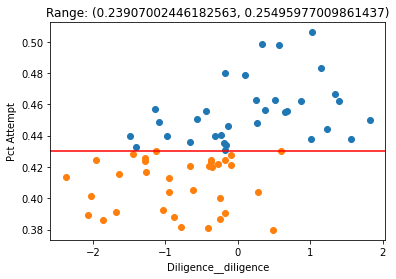

INFO:analytics.session:******** P-Hint range: (0.25495977009861437, 0.27084951573540317) *********
INFO:analytics.session:Number of rows: 98
INFO:analytics.session:0.4235259272548986
INFO:analytics.session:Pct Attempt Correlation with Diligence__diligence over range (0.25495977009861437, 0.27084951573540317): 
R = 0.6659635617031816	 pval = 7.292475205747426e-14


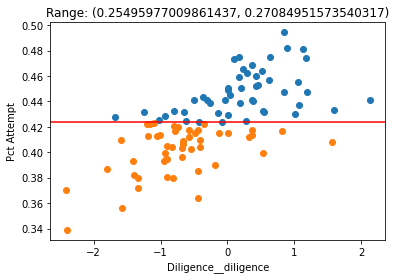

INFO:analytics.session:******** P-Hint range: (0.27084951573540317, 0.28673926137219197) *********
INFO:analytics.session:Number of rows: 76
INFO:analytics.session:0.42150676219158606
INFO:analytics.session:Pct Attempt Correlation with Diligence__diligence over range (0.27084951573540317, 0.28673926137219197): 
R = 0.6960814505138253	 pval = 2.9434473840028335e-12


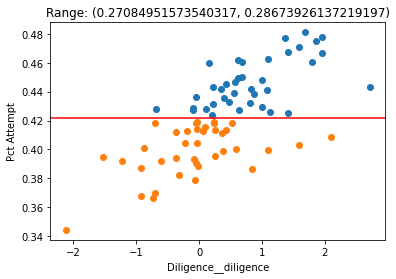

INFO:analytics.session:******** P-Hint range: (0.28673926137219197, 0.30262900700898077) *********
INFO:analytics.session:Number of rows: 68
INFO:analytics.session:0.42458092932675684
INFO:analytics.session:Pct Attempt Correlation with Diligence__diligence over range (0.28673926137219197, 0.30262900700898077): 
R = 0.6805100593840472	 pval = 1.7266768317306867e-10


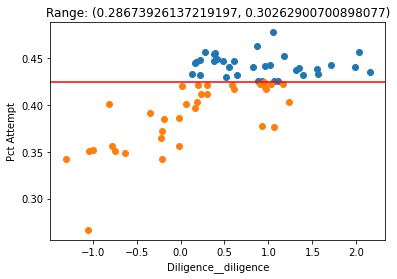

INFO:analytics.session:******** P-Hint range: (0.3026290070089807, 0.31851875264576945) *********
INFO:analytics.session:Number of rows: 22
INFO:analytics.session:0.4203364812217088
INFO:analytics.session:Pct Attempt Correlation with Diligence__diligence over range (0.3026290070089807, 0.31851875264576945): 
R = 0.6429985215270625	 pval = 0.0012477163042793188


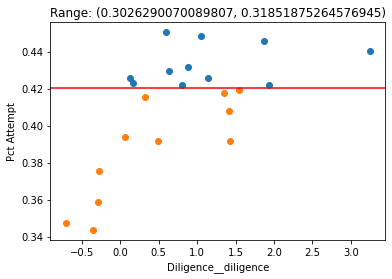

INFO:analytics.session:******** P-Hint range: (0.31851875264576945, 0.33440849828255825) *********
INFO:analytics.session:Number of rows: 17
INFO:analytics.session:0.3923013923013923
INFO:analytics.session:Pct Attempt Correlation with Diligence__diligence over range (0.31851875264576945, 0.33440849828255825): 
R = 0.7613202689548748	 pval = 0.0003849986285572351


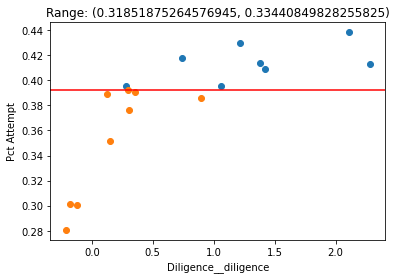

INFO:analytics.session:******** P-Hint range: (0.33440849828255825, 0.35029824391934705) *********
INFO:analytics.session:Number of rows: 6
INFO:analytics.session:0.36942376619795975
INFO:analytics.session:Pct Attempt Correlation with Diligence__diligence over range (0.33440849828255825, 0.35029824391934705): 
R = 0.5542800290937372	 pval = 0.2537246716483135


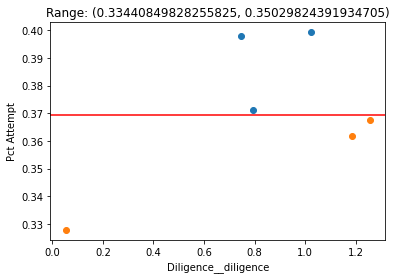

INFO:analytics.session:******** P-Hint range: (0.35029824391934705, 0.36618798955613585) *********
INFO:analytics.session:Number of rows: 3
INFO:analytics.session:0.36290967226219023
INFO:analytics.session:Pct Attempt Correlation with Diligence__diligence over range (0.35029824391934705, 0.36618798955613585): 
R = 0.8232523036942612	 pval = 0.38431444822409033


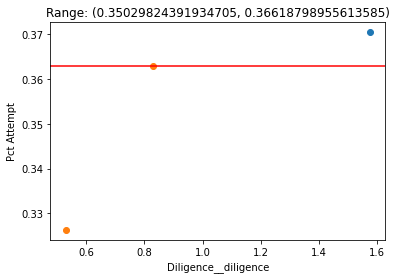

INFO:analytics.session:(0.20729053318824808, 0.22318027882503685)    0.399546
(0.22318027882503685, 0.23907002446182563)    0.425711
(0.23907002446182563, 0.25495977009861437)    0.430207
(0.25495977009861437, 0.27084951573540317)    0.423526
(0.27084951573540317, 0.28673926137219197)    0.421507
(0.28673926137219197, 0.30262900700898077)    0.424581
(0.3026290070089807, 0.31851875264576945)     0.420336
(0.31851875264576945, 0.33440849828255825)    0.392301
(0.33440849828255825, 0.35029824391934705)    0.369424
(0.35029824391934705, 0.36618798955613585)    0.362910
dtype: float64


In [141]:
tests = {desc: None for desc in batch_descs}
test_perfs  = {desc: None for desc in batch_descs}
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    col = 'Pct HintRequest'
#     col = 'Pct Attempt'
    for i in range(5):
        logger.info(f"**************************************************")
    logger.info(f"************** {desc} ******************")
    for i in range(5):
        logger.info(f"**************************************************")

    ycol = 'Pct Attempt'
    xcol = 'Diligence__diligence'
    x = sstats[xcol]
    y = sstats[ycol]

    corr, pval = pearsonr(x,y)
    logger.info(f"{ycol} Correlation with {xcol} over all data: \nR = {corr}\t pval = {pval}")

    num_parts = 10
    rmin = np.min(sstats[col])
    rmax = np.max(sstats[col])
    delta = (rmax - rmin) / num_parts
    start_range = np.arange(rmin,rmax,delta)
    end_range = start_range + delta
    ranges = [r for r in zip(start_range, end_range)]
    test = pd.DataFrame(index=sstats.index, columns=[str(r) for r in ranges])
    test_perf = pd.DataFrame(index=sstats.index, columns=[str(r) for r in ranges])
    threses = pd.Series(index=ranges)
    for r in ranges:
        logger.info(f"******** P-Hint range: {r} *********")
        rows = (sstats[col] >= r[0]) & (sstats[col] < r[1])
        logger.info(f"Number of rows: {np.sum(rows)}")
        test[str(r)] = rows
        ycol = 'Pct Attempt'
#         ycol = 'Pct HintRequest'
        xcol = 'Diligence__diligence'
        x = sstats.loc[rows, xcol]
        y = sstats.loc[rows, ycol]
        thres = np.median(y)
        threses[r] = thres
        logger.info(thres)
        perf = y > thres
        test_perf.loc[rows, r] = perf
        plt.scatter(x[perf],y[perf])
        plt.scatter(x[~perf],y[~perf])
        plt.axhline(y = thres, color = 'r', linestyle = '-')
        plt.xlabel(xcol)
        plt.ylabel(ycol)
        plt.title(f"Range: {r}")
        corr, pval = pearsonr(x,y)
        logger.info(f"{ycol} Correlation with {xcol} over range {r}: \nR = {corr}\t pval = {pval}")
        plt.show()
        
    tests[desc] = test
    test_perfs[desc] = test_perf
    logger.info(threses)

In [103]:
from scipy.optimize import minimize

In [134]:
init_a = 1
init_b = 0

def sigmoid_2pl(a,b,t):
    return 1 / (1 + math.exp(-a*(t - b)))

def eval_sigmoid(params,theta):
    a = params[0]
    b = params[1]
    theta_hat = theta.apply(lambda x: sigmoid_2pl(a,b,x))
    mse = np.mean((theta - theta_hat)**2)
    return mse

for i,desc in enumerate(batch_descs):
    test = tests[desc]
    test_perf = test_perfs[desc]
    sstats = stu_stats[desc]
    usable_items = []
    obs_freq = test.sum(axis=0)
    thres = 15
    usable_items = test.columns[obs_freq > thres]
    item_params = pd.DataFrame(index=usable_items, columns=['a', 'b'])
    item_params['a'] = init_a
    item_params['b'] = init_b
    for item in usable_items:
        logger.info("*****************************************************")
        logger.info(f"Fitting parameters for dataset, {desc}, \nand test item: {item}")
        logger.info("*****************************************************")
        sids = test.index[test[item]]
        logger.info(f"Getting ability for {len(sids)} students")
        theta_name = 'Diligence__diligence'
        thetas = sstats.loc[sids, theta_name]
        params = list(item_params.loc[item])
        opt_result = minimize(eval_sigmoid, params, args=(thetas,))
        item_params.loc[item] = opt_result.x
        logger.info(f"Optimized 2pl parameters: {opt_result.x}")
        
        
        

INFO:analytics.session:*****************************************************
INFO:analytics.session:Fitting parameters for dataset, Simple diligent students, 
and test item: (0.3764185309300242, 0.3909664360477136)
INFO:analytics.session:*****************************************************
INFO:analytics.session:Getting ability for 17 students
INFO:analytics.session:Optimized 2pl parameters: [6.29603679 0.49564116]
INFO:analytics.session:*****************************************************
INFO:analytics.session:Fitting parameters for dataset, Simple diligent students, 
and test item: (0.3909664360477136, 0.40551434116540297)
INFO:analytics.session:*****************************************************
INFO:analytics.session:Getting ability for 49 students
INFO:analytics.session:Optimized 2pl parameters: [7.64344043 0.49445988]
INFO:analytics.session:*****************************************************
INFO:analytics.session:Fitting parameters for dataset, Simple diligent students, 
